In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from fairlearn.metrics import MetricFrame, demographic_parity_difference, equalized_odds_difference, selection_rate, true_positive_rate, false_positive_rate, false_negative_rate
from fairlearn.postprocessing import ThresholdOptimizer
from fairlearn.reductions import ExponentiatedGradient, DemographicParity
from sklearn.metrics import ConfusionMatrixDisplay

# Load the cleaned dataset
data = pd.read_csv('cleaned_communities_crime_data.csv')

# Define the target and features
target = 'ViolentCrimesPerPop'
features = data.drop(columns=[target])
sensitive_feature = 'PctFam2Par'

# Binarize the target variable based on the mean
threshold = data[target].mean()
data['ViolentCrimesPerPop_binary'] = (data[target] > threshold).astype(int)

# Discretize the sensitive feature
data['PctFam2Par_bin'] = pd.cut(data['PctFam2Par'], bins=5, labels=False)


In [2]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    features, data['ViolentCrimesPerPop_binary'], test_size=0.2, random_state=42
)

# Train a Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict using the trained model
y_pred = rf_model.predict(X_test)

# Define custom metric functions
def accuracy(y_true, y_pred):
    return accuracy_score(y_true, y_pred)

def precision(y_true, y_pred):
    return precision_score(y_true, y_pred, zero_division=0)

def recall(y_true, y_pred):
    return recall_score(y_true, y_pred, zero_division=0)

def f1(y_true, y_pred):
    return f1_score(y_true, y_pred, zero_division=0)

# Compute metrics for different groups
metrics = MetricFrame(
    metrics={
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    },
    y_true=y_test,
    y_pred=y_pred,
    sensitive_features=data.loc[X_test.index, 'PctFam2Par_bin']
)

# Print the overall metrics
print("Overall Metrics:")
print(metrics.overall)

# Print metrics by sensitive feature groups
print("\nMetrics by Sensitive Feature Groups:")
print(metrics.by_group)


Overall Metrics:
accuracy     0.802198
precision    0.620690
recall       0.720000
f1           0.666667
dtype: float64

Metrics by Sensitive Feature Groups:
                accuracy  precision    recall        f1
PctFam2Par_bin                                         
0               0.600000   0.500000  1.000000  0.666667
1               0.666667   0.666667  0.857143  0.750000
2               0.814815   0.692308  0.900000  0.782609
3               0.766667   0.333333  0.166667  0.222222
4               1.000000   0.000000  0.000000  0.000000


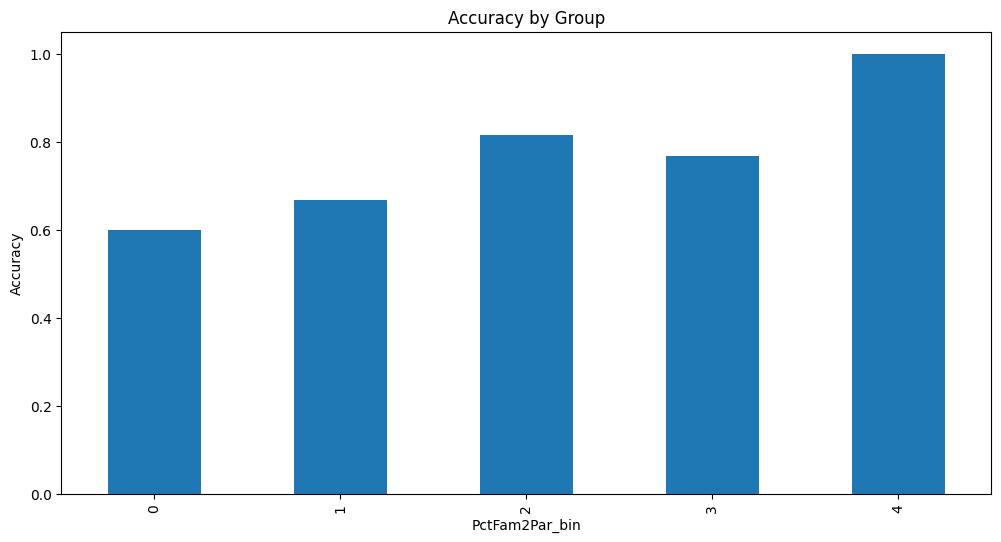

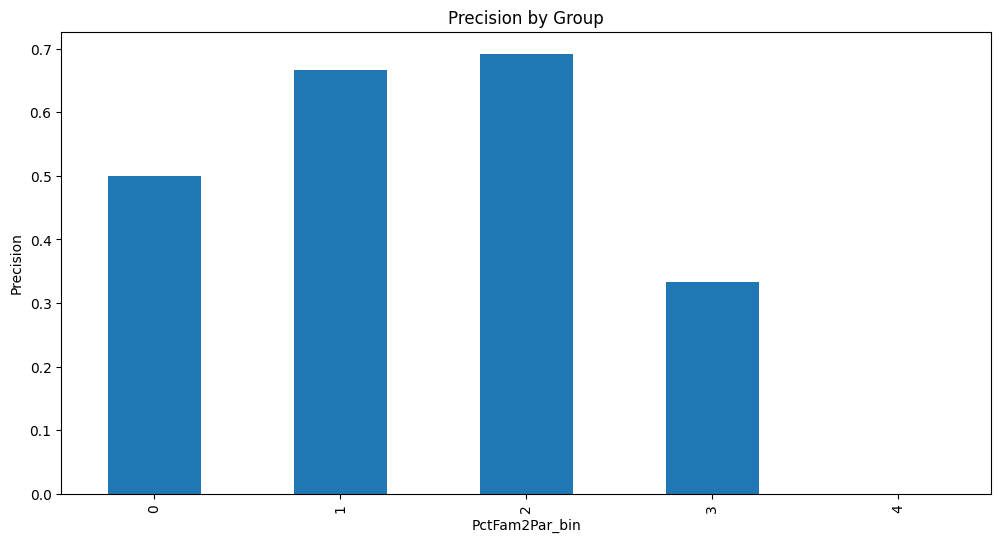

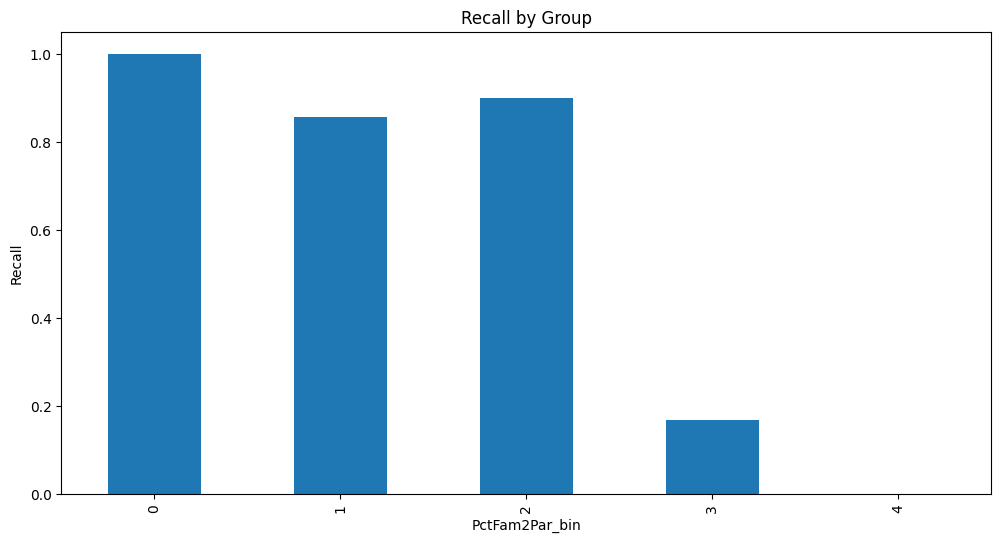

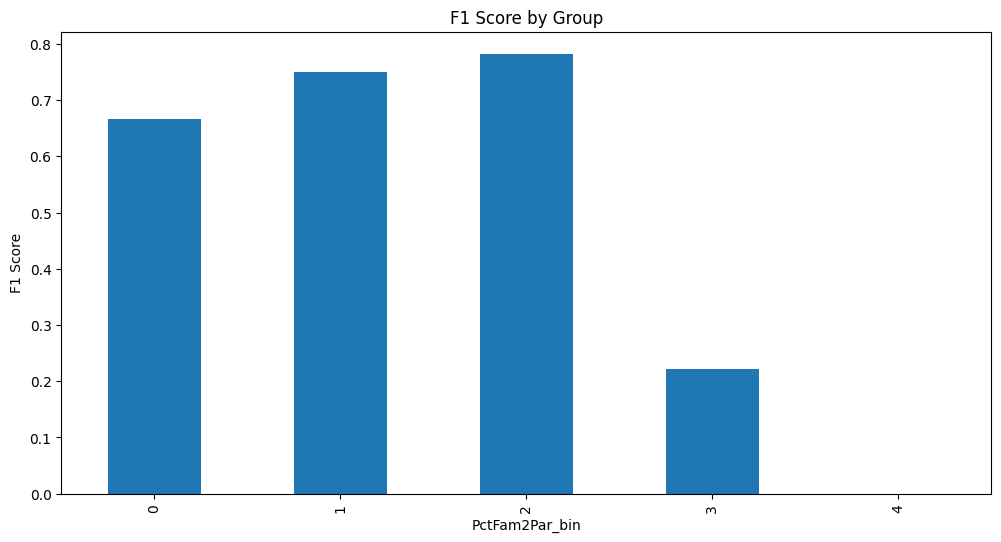

In [3]:
# Extract metrics for visualization
metrics_by_group = metrics.by_group
accuracy_by_group = metrics_by_group['accuracy']
precision_by_group = metrics_by_group['precision']
recall_by_group = metrics_by_group['recall']
f1_by_group = metrics_by_group['f1']

# Plot Accuracy by Group
accuracy_by_group.plot(kind='bar', figsize=(12, 6), title='Accuracy by Group')
plt.ylabel('Accuracy')
plt.show()

# Plot Precision by Group
precision_by_group.plot(kind='bar', figsize=(12, 6), title='Precision by Group')
plt.ylabel('Precision')
plt.show()

# Plot Recall by Group
recall_by_group.plot(kind='bar', figsize=(12, 6), title='Recall by Group')
plt.ylabel('Recall')
plt.show()

# Plot F1 Score by Group
f1_by_group.plot(kind='bar', figsize=(12, 6), title='F1 Score by Group')
plt.ylabel('F1 Score')
plt.show()


In [4]:
# Custom Metric Functions
def false_positive_rate_custom(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
    return fp / (fp + tn)

def false_negative_rate_custom(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
    return fn / (fn + tp)

def selection_rate_custom(y_pred):
    return np.mean(y_pred)

def false_omission_rate_custom(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
    return fn / (fn + tn)

def true_negative_rate_custom(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
    return tn / (tn + fp)

# Define difference functions
def false_positive_rate_difference(y_true, y_pred, sensitive_features):
    groups = np.unique(sensitive_features)
    rates = []
    for group in groups:
        mask = (sensitive_features == group)
        rates.append(false_positive_rate_custom(y_true[mask], y_pred[mask]))
    return np.max(rates) - np.min(rates)

def false_negative_rate_difference(y_true, y_pred, sensitive_features):
    groups = np.unique(sensitive_features)
    rates = []
    for group in groups:
        mask = (sensitive_features == group)
        rates.append(false_negative_rate_custom(y_true[mask], y_pred[mask]))
    return np.max(rates) - np.min(rates)

def selection_rate_difference(y_pred, sensitive_features):
    groups = np.unique(sensitive_features)
    rates = []
    for group in groups:
        mask = (sensitive_features == group)
        rates.append(selection_rate_custom(y_pred[mask]))
    return np.max(rates) - np.min(rates)

def false_omission_rate_difference(y_true, y_pred, sensitive_features):
    groups = np.unique(sensitive_features)
    rates = []
    for group in groups:
        mask = (sensitive_features == group)
        rates.append(false_omission_rate_custom(y_true[mask], y_pred[mask]))
    return np.max(rates) - np.min(rates)

def true_negative_rate_difference(y_true, y_pred, sensitive_features):
    groups = np.unique(sensitive_features)
    rates = []
    for group in groups:
        mask = (sensitive_features == group)
        rates.append(true_negative_rate_custom(y_true[mask], y_pred[mask]))
    return np.max(rates) - np.min(rates)


In [5]:
# Calculate fairness metrics for the base model
dpd = demographic_parity_difference(y_test, y_pred, sensitive_features=data.loc[X_test.index, 'PctFam2Par_bin'])
eod = equalized_odds_difference(y_test, y_pred, sensitive_features=data.loc[X_test.index, 'PctFam2Par_bin'])
fprd = false_positive_rate_difference(y_test, y_pred, sensitive_features=data.loc[X_test.index, 'PctFam2Par_bin'])
fnrd = false_negative_rate_difference(y_test, y_pred, sensitive_features=data.loc[X_test.index, 'PctFam2Par_bin'])
srd = selection_rate_difference(y_pred, sensitive_features=data.loc[X_test.index, 'PctFam2Par_bin'])
for_diff = false_omission_rate_difference(y_test, y_pred, sensitive_features=data.loc[X_test.index, 'PctFam2Par_bin'])
tnr_diff = true_negative_rate_difference(y_test, y_pred, sensitive_features=data.loc[X_test.index, 'PctFam2Par_bin'])

print(f"Demographic Parity Difference: {dpd}")
print(f"Equalized Odds Difference: {eod}")
print(f"False Positive Rate Difference: {fprd}")
print(f"False Negative Rate Difference: {fnrd}")
print(f"Selection Rate Difference: {srd}")
print(f"False Omission Rate Difference: {for_diff}")
print(f"True Negative Rate Difference: {tnr_diff}")


Demographic Parity Difference: 0.8
Equalized Odds Difference: 1.0
False Positive Rate Difference: 0.6666666666666666
False Negative Rate Difference: nan
Selection Rate Difference: 0.8
False Omission Rate Difference: 0.3333333333333333
True Negative Rate Difference: 0.6666666666666667


C:\Users\Fujitsu\AppData\Local\Temp\ipykernel_9300\2464221156.py:8: RuntimeWarning: invalid value encountered in longlong_scalars
  return fn / (fn + tp)


C:\Users\Fujitsu\AppData\Local\Temp\ipykernel_9300\1926539352.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_black = df.groupby('PctFam2Par_bin').apply(lambda x: pd.Series({



Additional Metrics by 'PctFam2Par_bin':
                accuracy  precision    recall        f1
PctFam2Par_bin                                         
0               0.600000   0.500000  1.000000  0.666667
1               0.666667   0.666667  0.857143  0.750000
2               0.814815   0.692308  0.900000  0.782609
3               0.766667   0.333333  0.166667  0.222222
4               1.000000   0.000000  0.000000  0.000000


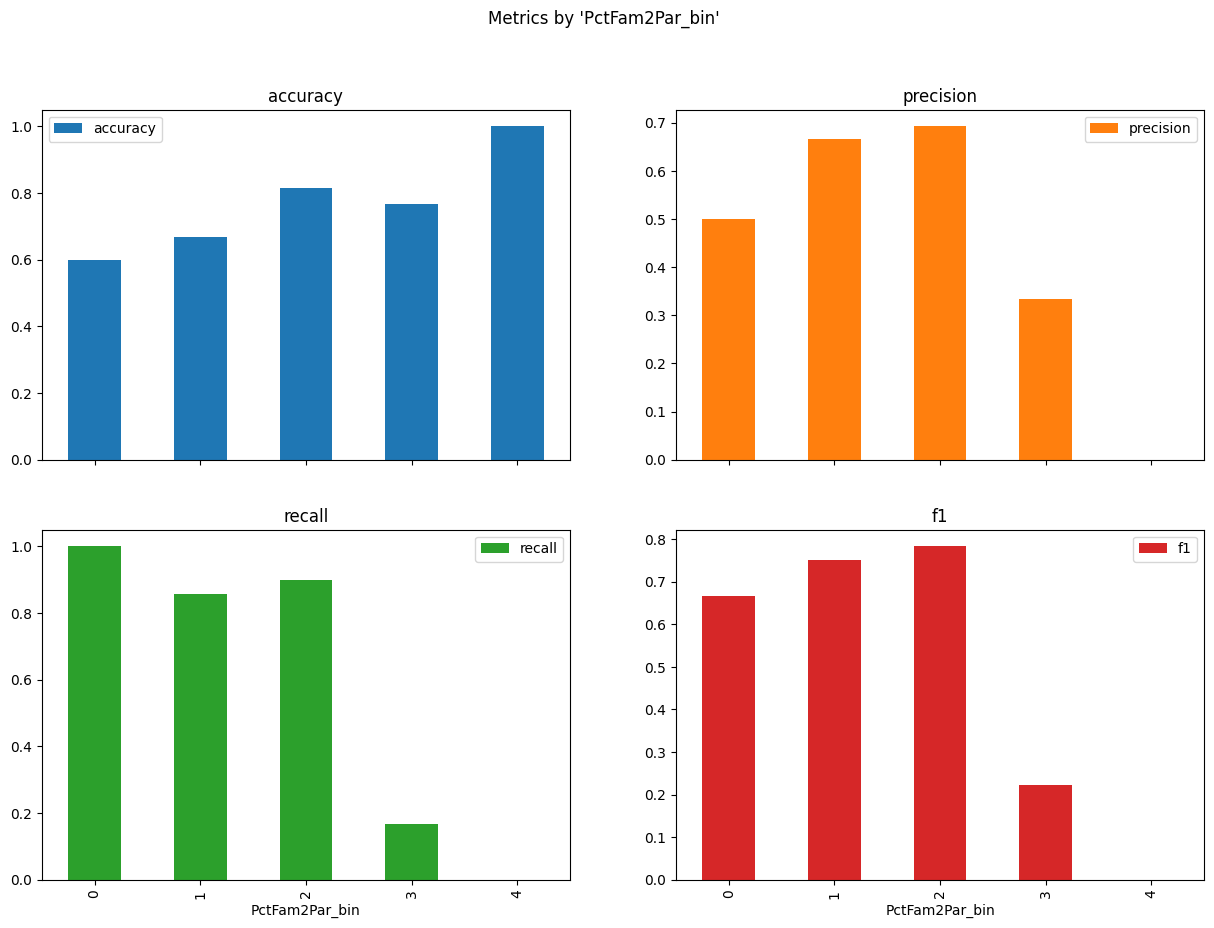

C:\Users\Fujitsu\AppData\Local\Temp\ipykernel_9300\2464221156.py:8: RuntimeWarning: invalid value encountered in longlong_scalars
  return fn / (fn + tp)



Additional Metrics by Sensitive Feature Groups:
                false_positive_rate  false_negative_rate  false_omission_rate  \
PctFam2Par_bin                                                                  
0                          0.666667             0.000000             0.000000   
1                          0.600000             0.142857             0.333333   
2                          0.235294             0.100000             0.071429   
3                          0.083333             0.833333             0.185185   
4                          0.000000                  NaN             0.000000   

                true_negative_rate  
PctFam2Par_bin                      
0                         0.333333  
1                         0.400000  
2                         0.764706  
3                         0.916667  
4                         1.000000  


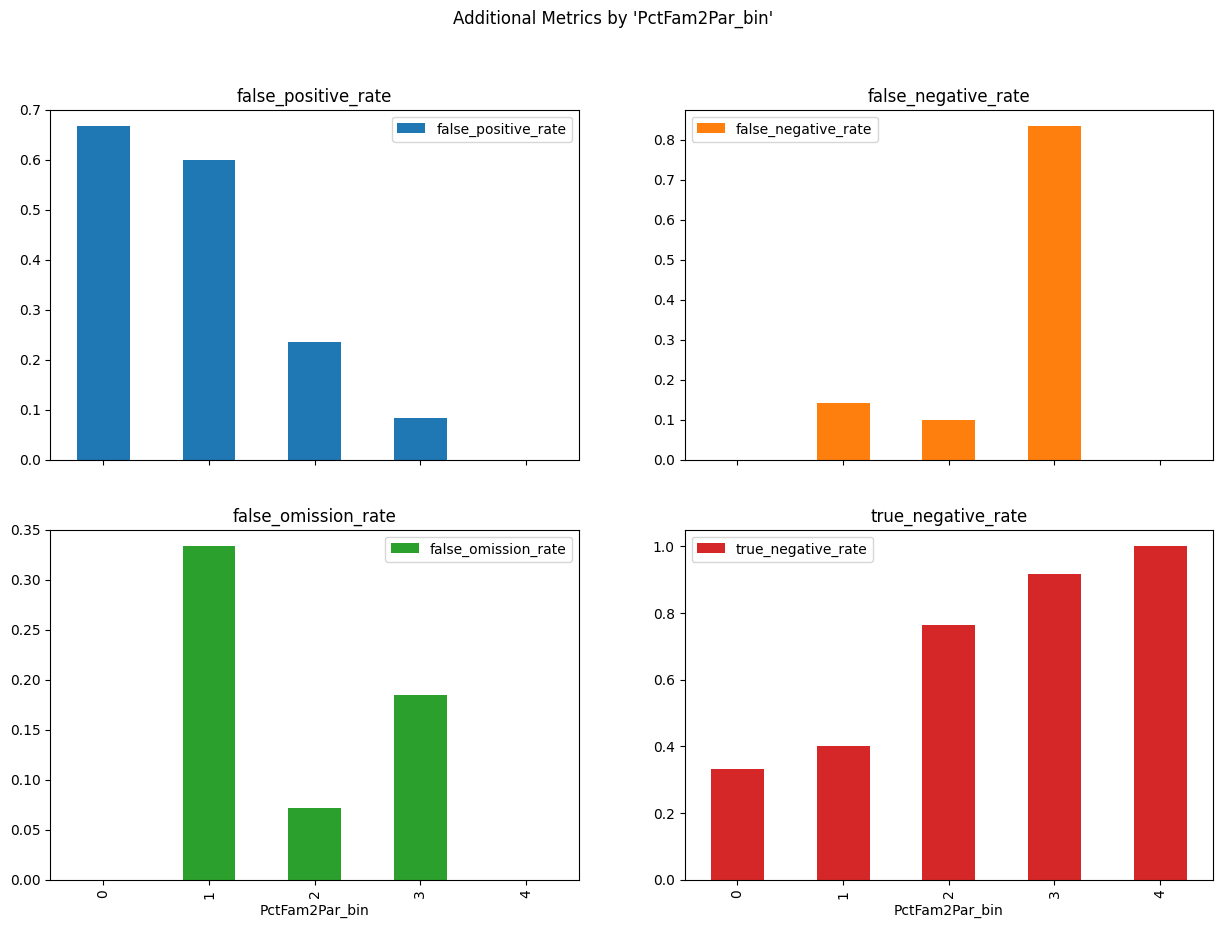


Summary of Fairness Metrics:
Demographic Parity Difference: 0.8
Equalized Odds Difference: 1.0
False Positive Rate Difference: 0.6666666666666666
False Negative Rate Difference: nan
Selection Rate Difference: 0.8
False Omission Rate Difference: 0.3333333333333333
True Negative Rate Difference: 0.6666666666666667


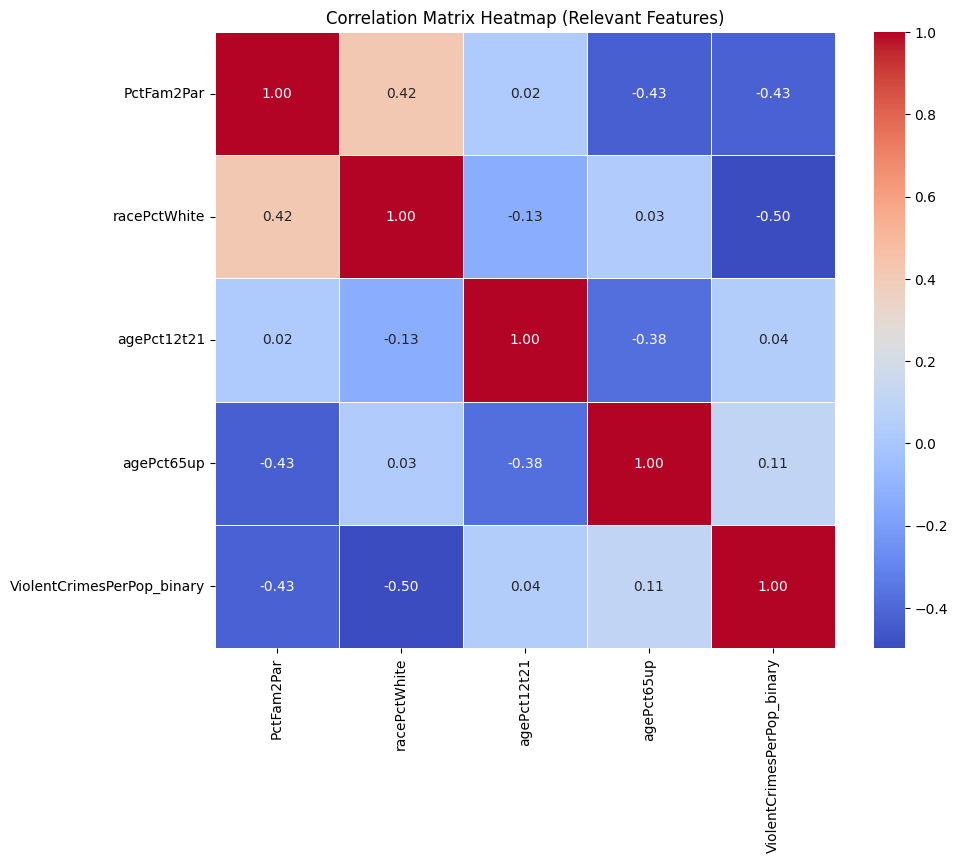

In [6]:
# Create a DataFrame for easier analysis
df = pd.DataFrame({
    'y_true': y_test,
    'y_pred': y_pred,
    'PctFam2Par_bin': data.loc[X_test.index, 'PctFam2Par_bin']
})

# Calculate additional metrics for each subgroup
grouped_black = df.groupby('PctFam2Par_bin').apply(lambda x: pd.Series({
    'accuracy': accuracy(x['y_true'], x['y_pred']),
    'precision': precision(x['y_true'], x['y_pred']),
    'recall': recall(x['y_true'], x['y_pred']),
    'f1': f1(x['y_true'], x['y_pred'])
}))

print("\nAdditional Metrics by 'PctFam2Par_bin':")
print(grouped_black)

# Plot additional metrics by 'pctfam2par_bin'
grouped_black.plot(kind='bar', subplots=True, layout=(2, 2), figsize=(15, 10), title="Metrics by 'PctFam2Par_bin'")
plt.show()

# Calculate additional fairness metrics
for_custom_metrics = {
    'false_positive_rate': false_positive_rate_custom,
    'false_negative_rate': false_negative_rate_custom,
    'false_omission_rate': false_omission_rate_custom,
    'true_negative_rate': true_negative_rate_custom
}

additional_metrics = MetricFrame(
    metrics=for_custom_metrics,
    y_true=y_test,
    y_pred=y_pred,
    sensitive_features=data.loc[X_test.index, 'PctFam2Par_bin']
)

# Print additional metrics by group
print("\nAdditional Metrics by Sensitive Feature Groups:")
print(additional_metrics.by_group)

# Plot additional metrics
additional_metrics.by_group.plot(kind='bar', subplots=True, layout=(2, 2), figsize=(15, 10), title="Additional Metrics by 'PctFam2Par_bin'")
plt.show()

# Summarize all fairness metrics
summary_metrics = {
    'Demographic Parity Difference': dpd,
    'Equalized Odds Difference': eod,
    'False Positive Rate Difference': fprd,
    'False Negative Rate Difference': fnrd,
    'Selection Rate Difference': srd,
    'False Omission Rate Difference': for_diff,
    'True Negative Rate Difference': tnr_diff
}

print("\nSummary of Fairness Metrics:")
for metric, value in summary_metrics.items():
    print(f"{metric}: {value}")

# Create heatmap of correlation matrix for relevant features
relevant_features = ['PctFam2Par', 'racePctWhite', 'agePct12t21', 'agePct65up', 'ViolentCrimesPerPop_binary']
corr_matrix = data[relevant_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', cbar=True, linewidths=0.5)
plt.title('Correlation Matrix Heatmap (Relevant Features)')
plt.show()


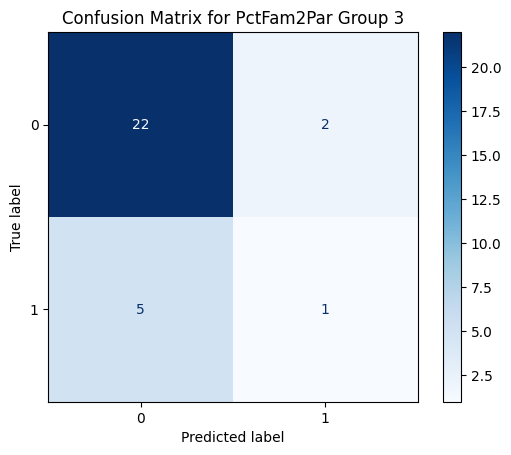

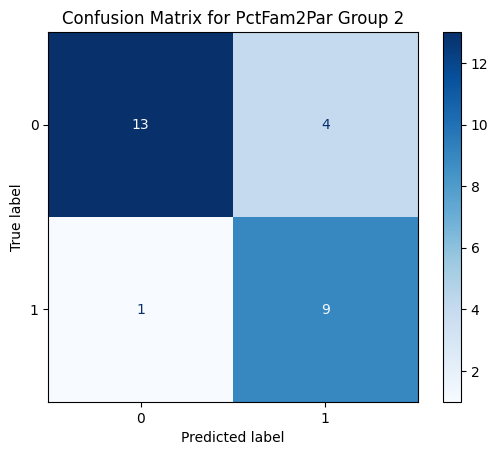

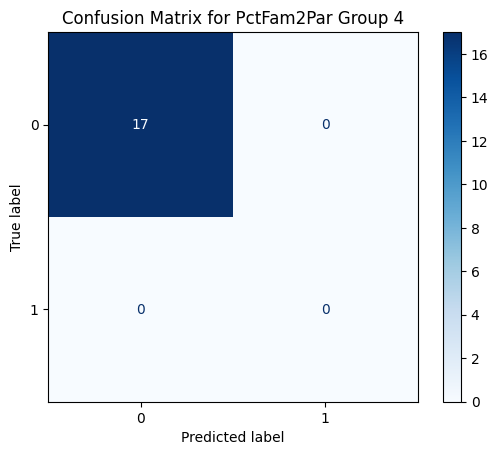

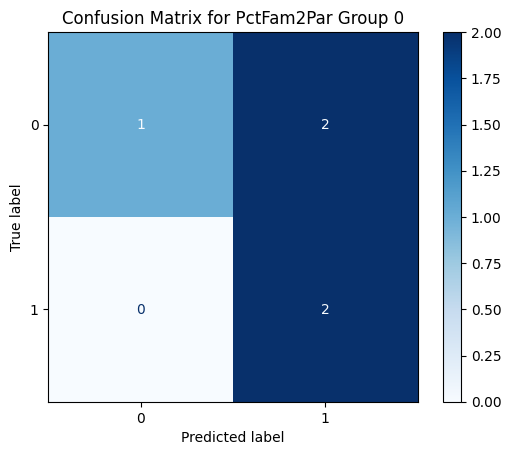

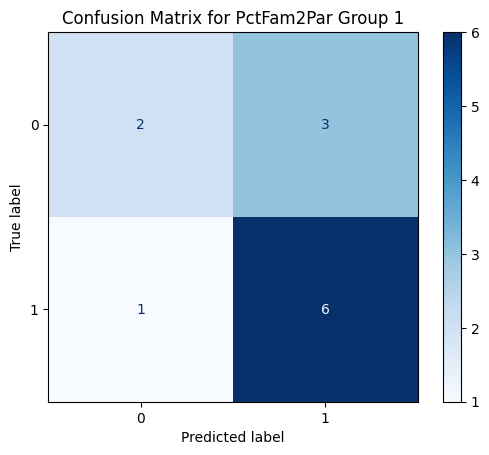

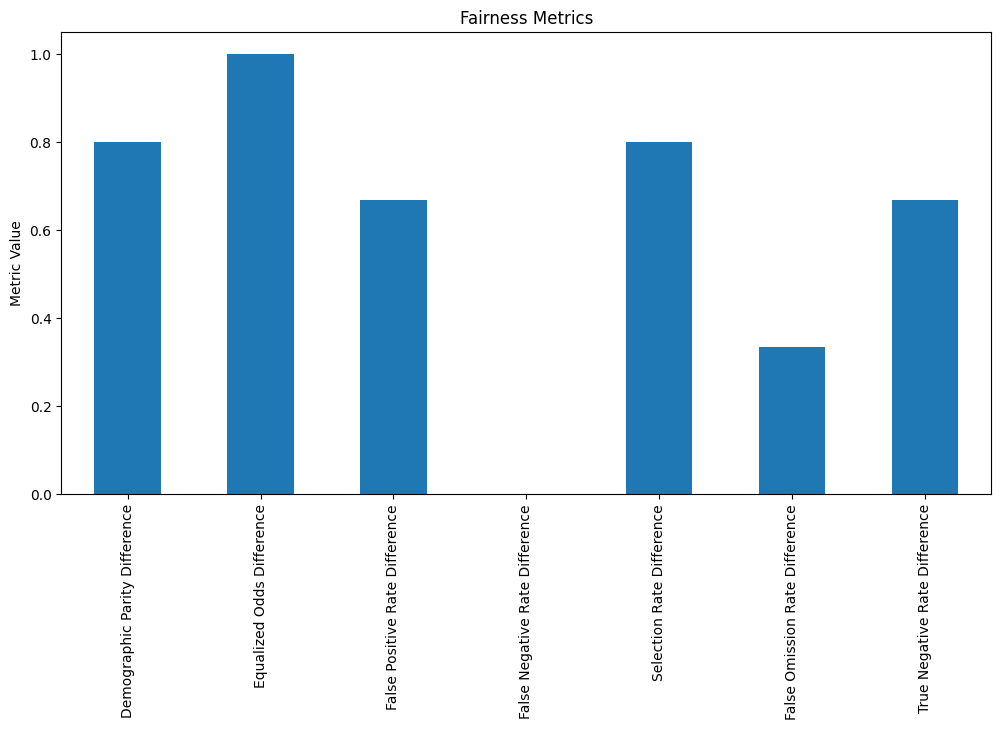

In [7]:
# Plot confusion matrix for pctfam2par_bin
for race_group in df['PctFam2Par_bin'].unique():
    subset = df[df['PctFam2Par_bin'] == race_group]
    if len(subset['y_true'].unique()) > 1:
        cm = confusion_matrix(subset['y_true'], subset['y_pred'], labels=[0, 1])
    else:
        cm = confusion_matrix(subset['y_true'], subset['y_pred'], labels=[0, 1], sample_weight=np.ones(len(subset['y_true'])))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix for PctFam2Par Group {race_group}')
    plt.show()

# Bar plot for fairness metrics
fairness_metrics = pd.Series(summary_metrics)
fairness_metrics.plot(kind='bar', figsize=(12, 6), title='Fairness Metrics')
plt.ylabel('Metric Value')
plt.show()

# Reweighing
def compute_sample_weights(data, sensitive_features, target):
    df = data.copy()
    df['weight'] = 1.0
    
    # Calculate the prevalence of each group
    group_counts = df.groupby(sensitive_features).size()
    total_count = len(df)
    
    for group, count in group_counts.items():
        group_weight = total_count / (len(group_counts) * count)
        df.loc[df[sensitive_features] == group, 'weight'] = group_weight
    
    return df['weight']


In [8]:
# Compute sample weights for training data
sample_weights = compute_sample_weights(data.loc[X_train.index], 'PctFam2Par_bin', 'ViolentCrimesPerPop_binary')

# Train a Random Forest model on the reweighed data
rf_model_rw = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_rw.fit(X_train, y_train, sample_weight=sample_weights)

# Predict using the trained model
y_pred_rw = rf_model_rw.predict(X_test)

# Compute metrics for different groups
metrics_rw = MetricFrame(
    metrics={
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    },
    y_true=y_test,
    y_pred=y_pred_rw,
    sensitive_features=data.loc[X_test.index, 'PctFam2Par_bin']
)

# Print the overall metrics
print("Overall Metrics after Reweighing:")
print(metrics_rw.overall)

# Print metrics by sensitive feature groups
print("\nMetrics by Sensitive Feature Groups after Reweighing:")
print(metrics_rw.by_group)


Overall Metrics after Reweighing:
accuracy     0.791209
precision    0.615385
recall       0.640000
f1           0.627451
dtype: float64

Metrics by Sensitive Feature Groups after Reweighing:
                accuracy  precision    recall        f1
PctFam2Par_bin                                         
0               0.600000   0.500000  1.000000  0.666667
1               0.750000   0.750000  0.857143  0.800000
2               0.740741   0.636364  0.700000  0.666667
3               0.766667   0.333333  0.166667  0.222222
4               1.000000   0.000000  0.000000  0.000000


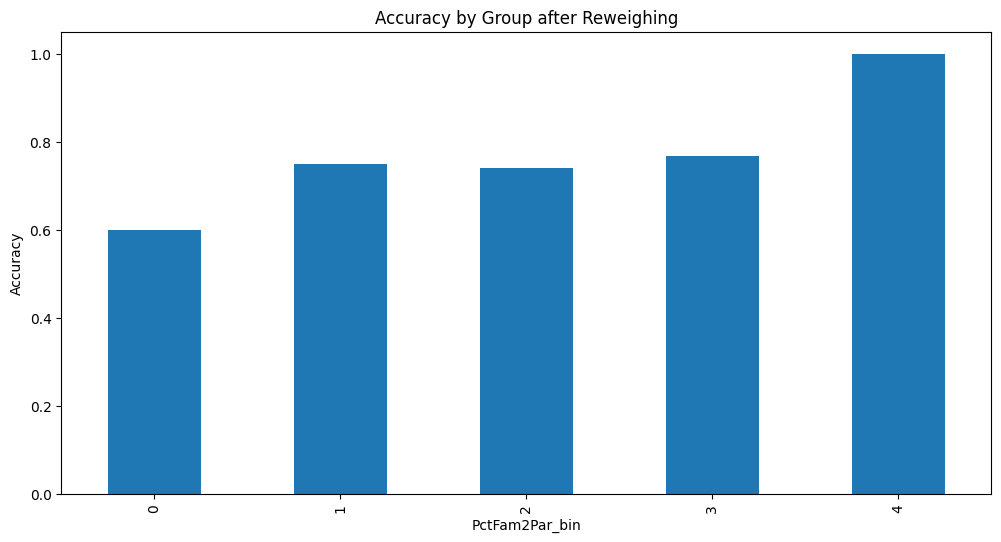

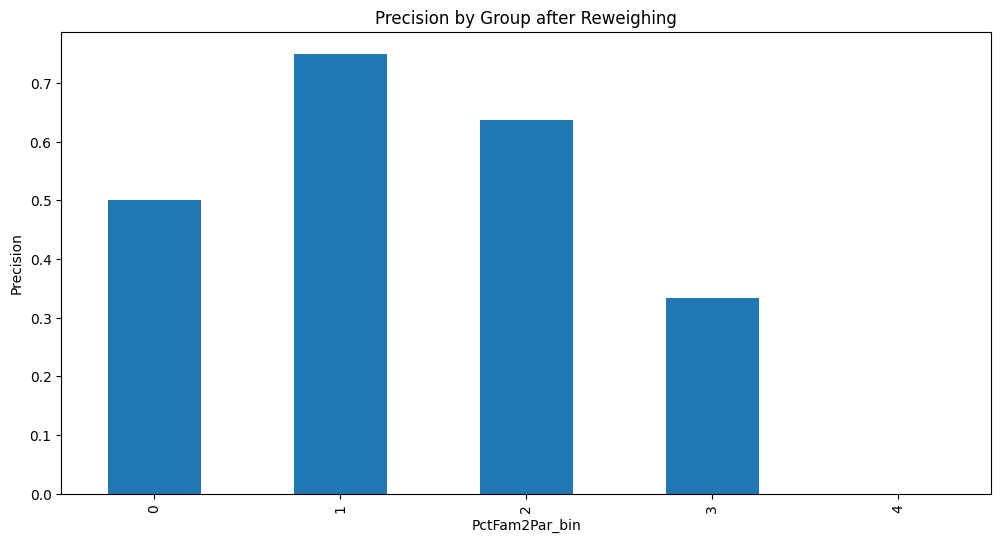

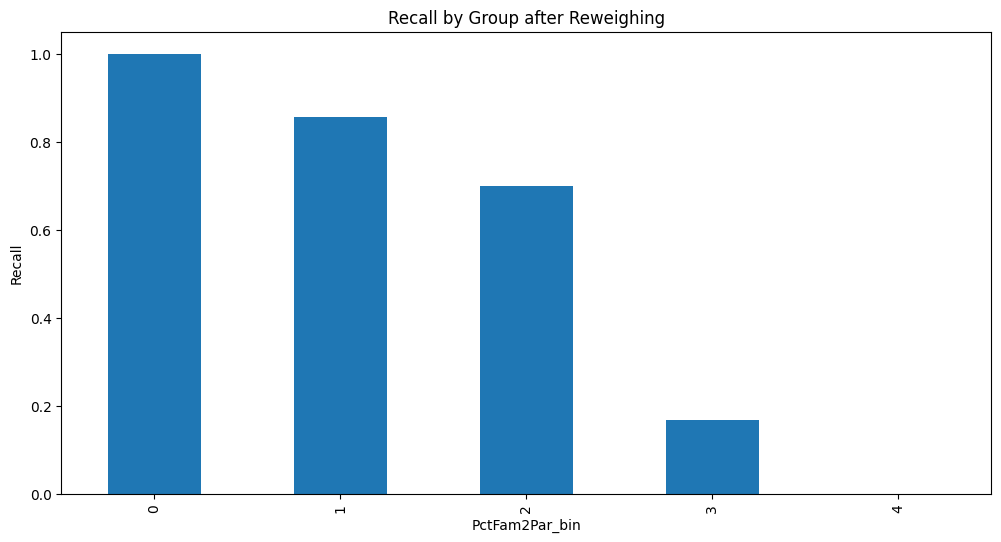

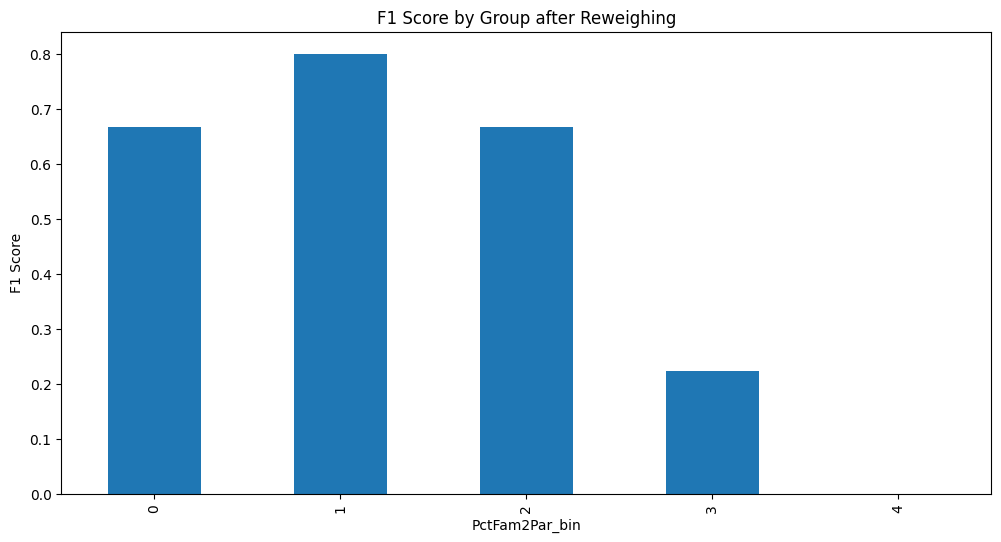

In [9]:
# Extract metrics for visualization
metrics_by_group_rw = metrics_rw.by_group
accuracy_rw = metrics_by_group_rw['accuracy']
precision_rw = metrics_by_group_rw['precision']
recall_rw = metrics_by_group_rw['recall']
f1_rw = metrics_by_group_rw['f1']

# Plot Accuracy by Group after Reweighing
accuracy_rw.plot(kind='bar', figsize=(12, 6), title='Accuracy by Group after Reweighing')
plt.ylabel('Accuracy')
plt.show()

# Plot Precision by Group after Reweighing
precision_rw.plot(kind='bar', figsize=(12, 6), title='Precision by Group after Reweighing')
plt.ylabel('Precision')
plt.show()

# Plot Recall by Group after Reweighing
recall_rw.plot(kind='bar', figsize=(12, 6), title='Recall by Group after Reweighing')
plt.ylabel('Recall')
plt.show()

# Plot F1 Score by Group after Reweighing
f1_rw.plot(kind='bar', figsize=(12, 6), title='F1 Score by Group after Reweighing')
plt.ylabel('F1 Score')
plt.show()


In [10]:
# Perform adversarial debiasing using Exponentiated Gradient Reduction
mitigator = ExponentiatedGradient(estimator=RandomForestClassifier(random_state=42), 
                                  constraints=DemographicParity())

mitigator.fit(X_train, y_train, sensitive_features=data.loc[X_train.index, 'PctFam2Par_bin'])

y_pred_ad = mitigator.predict(X_test)

# Compute metrics for different groups
metrics_ad = MetricFrame(
    metrics={
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    },
    y_true=y_test,
    y_pred=y_pred_ad,
    sensitive_features=data.loc[X_test.index, 'PctFam2Par_bin']
)

# Print the overall metrics
print("Overall Metrics after Adversarial Debiasing:")
print(metrics_ad.overall)

# Print metrics by sensitive feature groups
print("\nMetrics by Sensitive Feature Groups after Adversarial Debiasing:")
print(metrics_ad.by_group)


C:\Users\Fujitsu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  s

Overall Metrics after Adversarial Debiasing:
accuracy     0.637363
precision    0.366667
recall       0.440000
f1           0.400000
dtype: float64

Metrics by Sensitive Feature Groups after Adversarial Debiasing:
                accuracy  precision    recall        f1
PctFam2Par_bin                                         
0               0.200000   0.000000  0.000000  0.000000
1               0.666667   0.800000  0.571429  0.666667
2               0.666667   0.555556  0.500000  0.526316
3               0.566667   0.181818  0.333333  0.235294
4               0.823529   0.000000  0.000000  0.000000


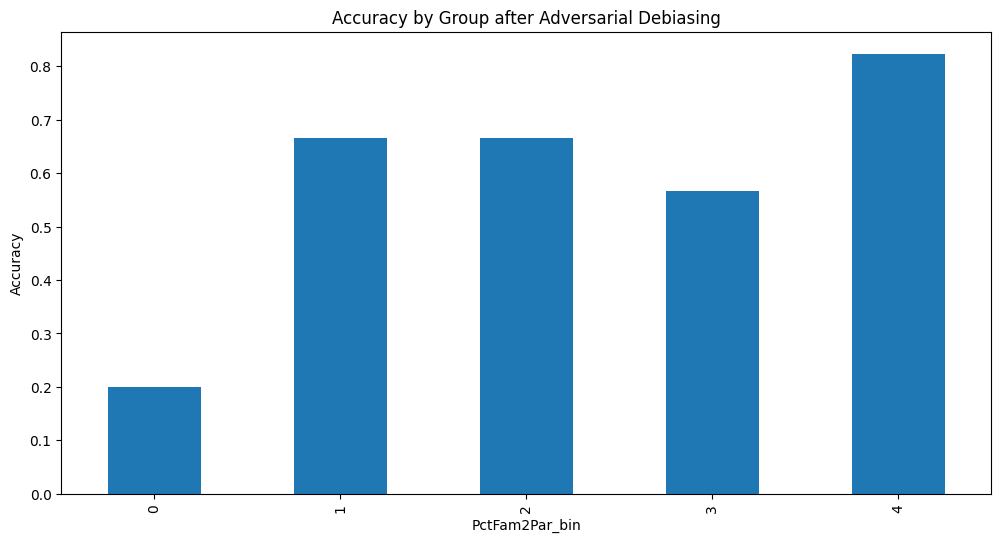

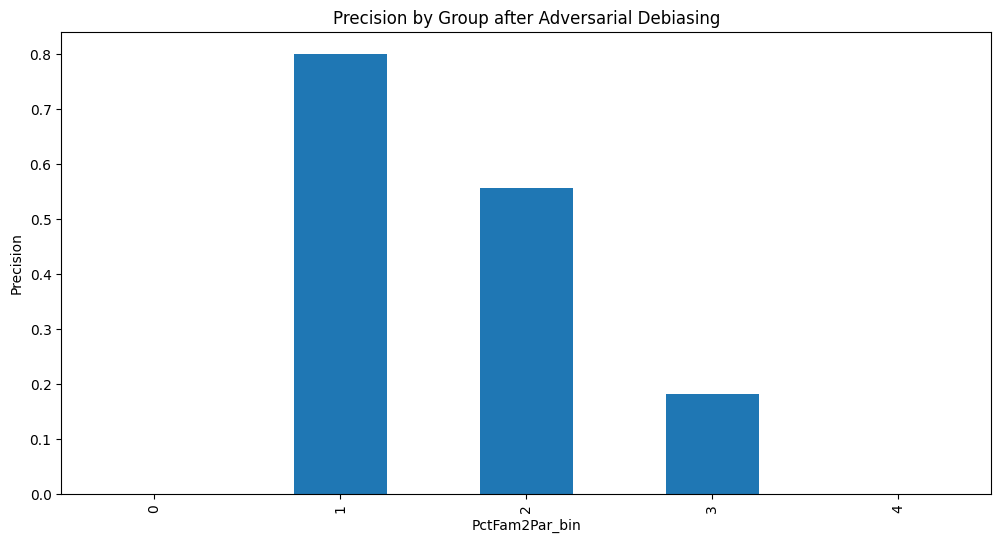

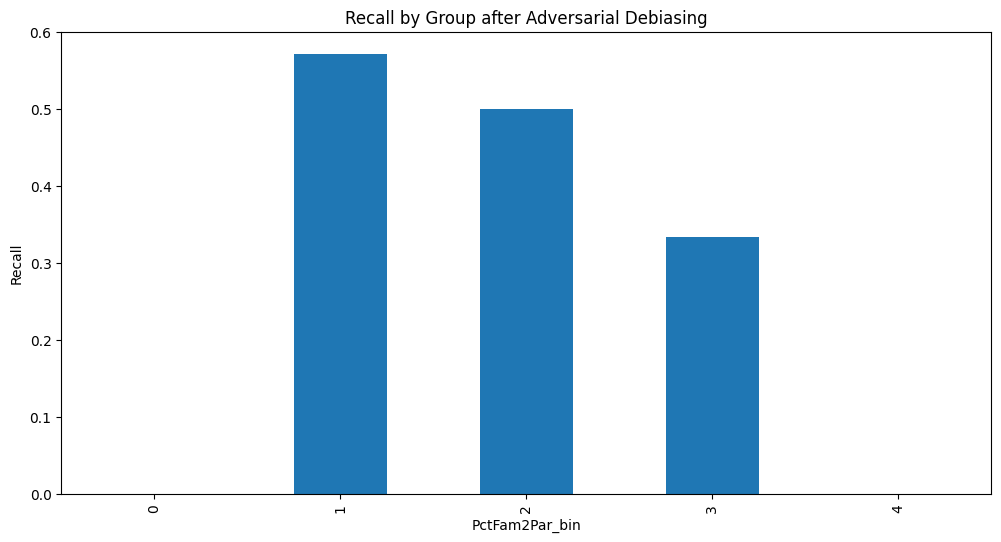

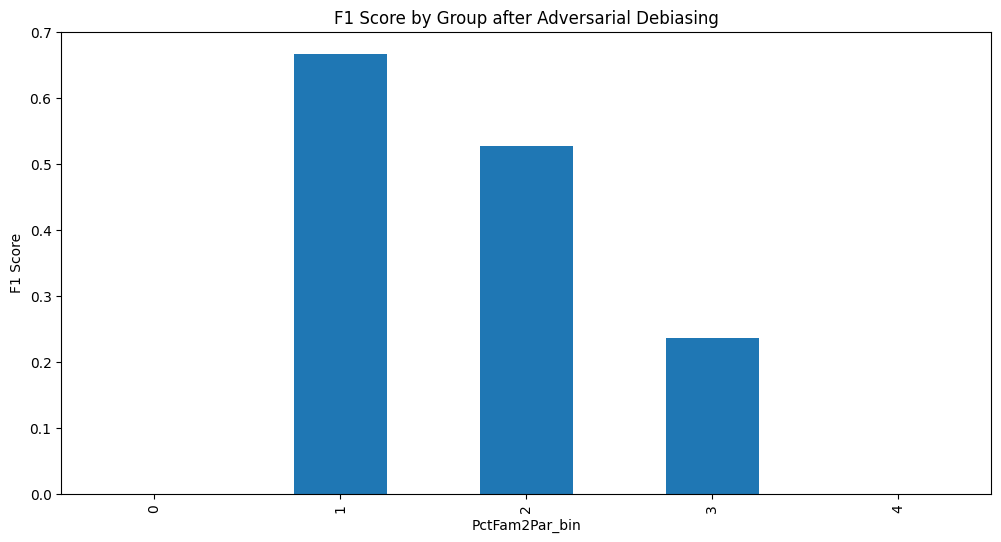

C:\Users\Fujitsu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\fairlearn\postprocessing\_threshold_optimizer.py:288: FutureWarning: 'predict_method' default value is changed from 'predict' to 'auto'. Explicitly pass `predict_method='predict' to replicate the old behavior, or pass `predict_method='auto' or other valid values to silence this warning.
  warn(


Overall Metrics after Post-processing:
accuracy     0.802198
precision    0.620690
recall       0.720000
f1           0.666667
dtype: float64

Metrics by Sensitive Feature Groups after Post-processing:
                accuracy  precision    recall        f1
PctFam2Par_bin                                         
0               0.600000   0.500000  1.000000  0.666667
1               0.666667   0.666667  0.857143  0.750000
2               0.814815   0.692308  0.900000  0.782609
3               0.766667   0.333333  0.166667  0.222222
4               1.000000   0.000000  0.000000  0.000000


In [11]:
# Extract metrics for visualization
metrics_by_group_ad = metrics_ad.by_group
accuracy_ad = metrics_by_group_ad['accuracy']
precision_ad = metrics_by_group_ad['precision']
recall_ad = metrics_by_group_ad['recall']
f1_ad = metrics_by_group_ad['f1']

# Plot Accuracy by Group after Adversarial Debiasing
accuracy_ad.plot(kind='bar', figsize=(12, 6), title='Accuracy by Group after Adversarial Debiasing')
plt.ylabel('Accuracy')
plt.show()

# Plot Precision by Group after Adversarial Debiasing
precision_ad.plot(kind='bar', figsize=(12, 6), title='Precision by Group after Adversarial Debiasing')
plt.ylabel('Precision')
plt.show()

# Plot Recall by Group after Adversarial Debiasing
recall_ad.plot(kind='bar', figsize=(12, 6), title='Recall by Group after Adversarial Debiasing')
plt.ylabel('Recall')
plt.show()

# Plot F1 Score by Group after Adversarial Debiasing
f1_ad.plot(kind='bar', figsize=(12, 6), title='F1 Score by Group after Adversarial Debiasing')
plt.ylabel('F1 Score')
plt.show()

# Perform post-processing using ThresholdOptimizer
postprocess_est = ThresholdOptimizer(estimator=rf_model, 
                                     constraints="equalized_odds", 
                                     prefit=True)

postprocess_est.fit(X_train, y_train, sensitive_features=data.loc[X_train.index, 'PctFam2Par_bin'])

y_pred_pp = postprocess_est.predict(X_test, sensitive_features=data.loc[X_test.index, 'PctFam2Par_bin'])

# Compute metrics for different groups
metrics_pp = MetricFrame(
    metrics={
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    },
    y_true=y_test,
    y_pred=y_pred_pp,
    sensitive_features=data.loc[X_test.index, 'PctFam2Par_bin']
)

# Print the overall metrics
print("Overall Metrics after Post-processing:")
print(metrics_pp.overall)

# Print metrics by sensitive feature groups
print("\nMetrics by Sensitive Feature Groups after Post-processing:")
print(metrics_pp.by_group)


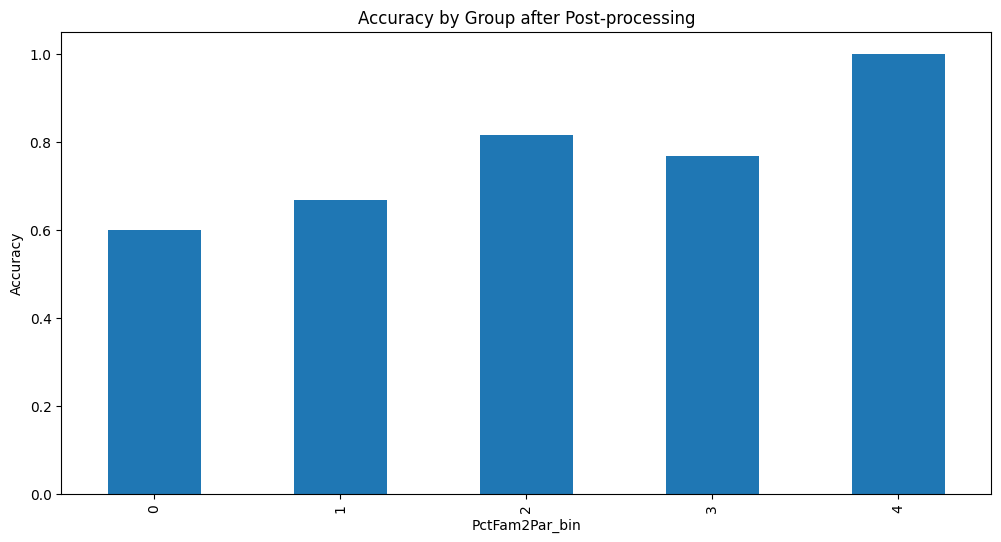

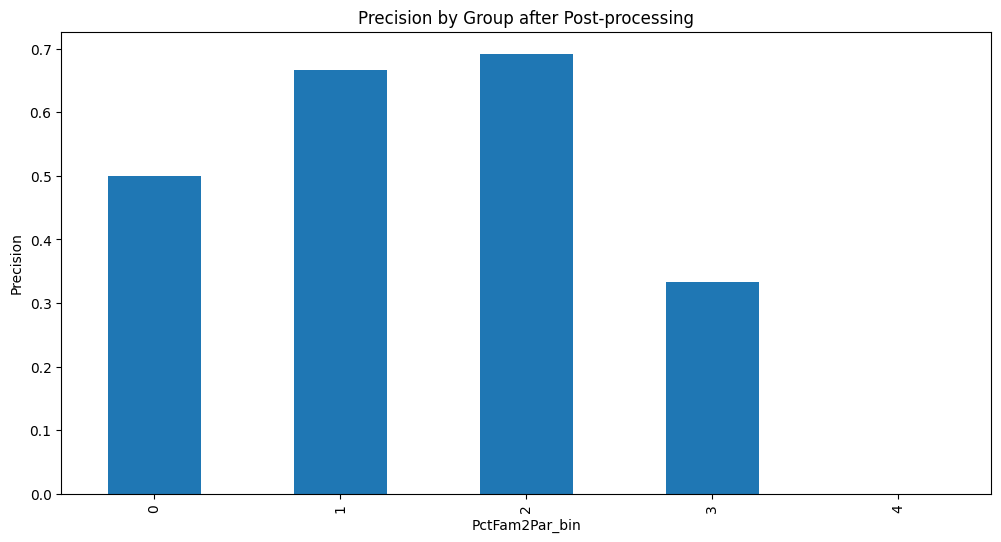

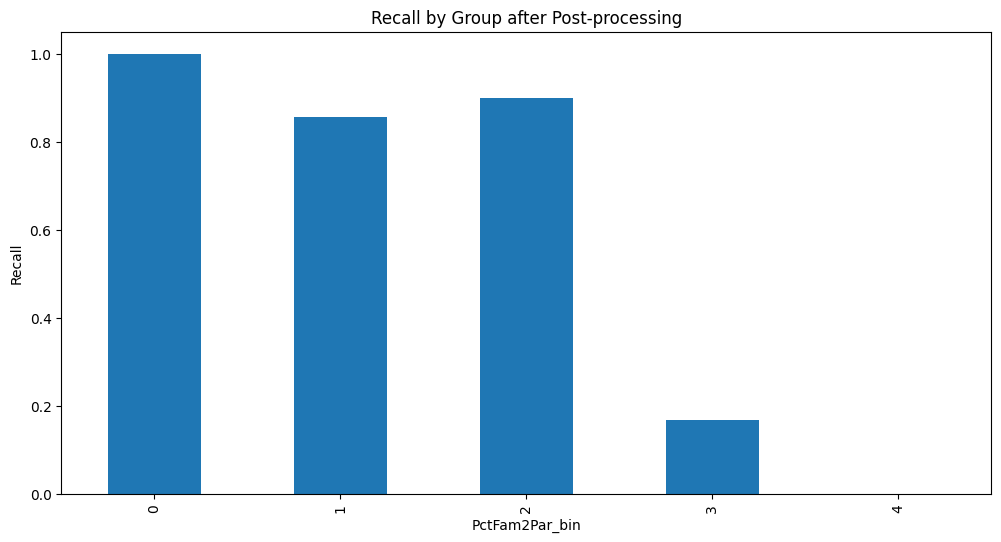

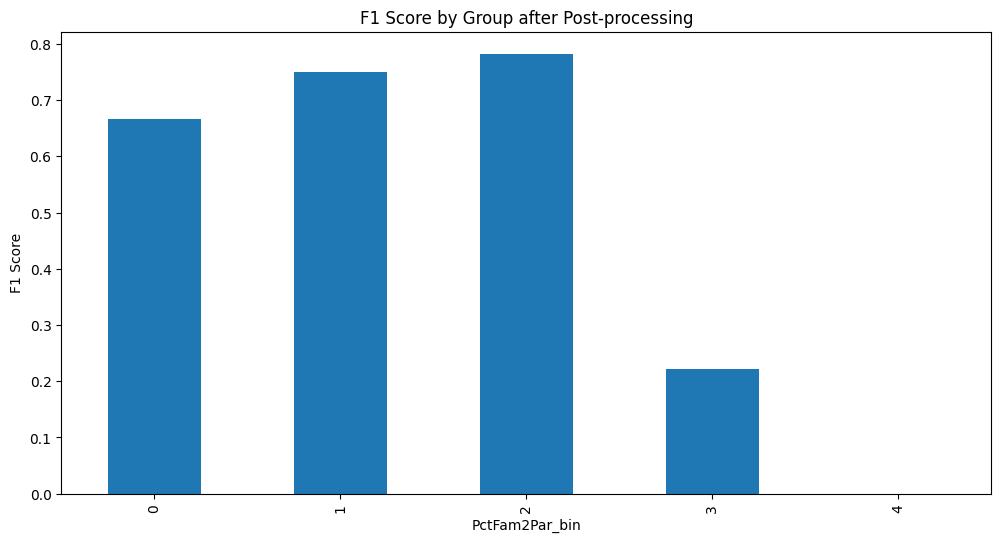

In [12]:
# Extract metrics for visualization
metrics_by_group_pp = metrics_pp.by_group
accuracy_pp = metrics_by_group_pp['accuracy']
precision_pp = metrics_by_group_pp['precision']
recall_pp = metrics_by_group_pp['recall']
f1_pp = metrics_by_group_pp['f1']

# Plot Accuracy by Group after Post-processing
accuracy_pp.plot(kind='bar', figsize=(12, 6), title='Accuracy by Group after Post-processing')
plt.ylabel('Accuracy')
plt.show()

# Plot Precision by Group after Post-processing
precision_pp.plot(kind='bar', figsize=(12, 6), title='Precision by Group after Post-processing')
plt.ylabel('Precision')
plt.show()

# Plot Recall by Group after Post-processing
recall_pp.plot(kind='bar', figsize=(12, 6), title='Recall by Group after Post-processing')
plt.ylabel('Recall')
plt.show()

# Plot F1 Score by Group after Post-processing
f1_pp.plot(kind='bar', figsize=(12, 6), title='F1 Score by Group after Post-processing')
plt.ylabel('F1 Score')
plt.show()


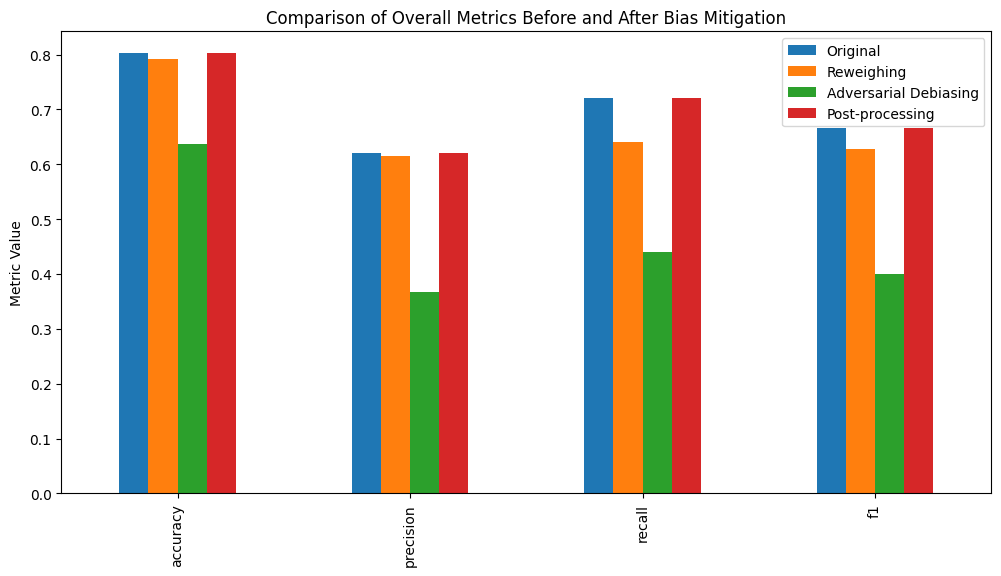

In [13]:
# Comparison of results before and after bias mitigation

# Create a DataFrame for comparison
comparison_df = pd.DataFrame({
    'Original': metrics.overall,
    'Reweighing': metrics_rw.overall,
    'Adversarial Debiasing': metrics_ad.overall,
    'Post-processing': metrics_pp.overall
})

# Plot comparison
comparison_df.plot(kind='bar', figsize=(12, 6), title='Comparison of Overall Metrics Before and After Bias Mitigation')
plt.ylabel('Metric Value')
plt.show()

# Function to plot comparison of metrics for different mitigation steps
def plot_metric_comparison(metrics_initial, metrics_rw, metrics_ad, metrics_pp, metric_name, ylabel, title):
    labels = metrics_initial.index

    x = np.arange(len(labels))
    width = 0.2

    fig, ax = plt.subplots(figsize=(12, 6))
    rects1 = ax.bar(x - width * 1.5, metrics_initial[metric_name], width, label='Initial')
    rects2 = ax.bar(x - width / 2, metrics_rw[metric_name], width, label='Reweighing')
    rects3 = ax.bar(x + width / 2, metrics_ad[metric_name], width, label='Adversarial Debiasing')
    rects4 = ax.bar(x + width * 1.5, metrics_pp[metric_name], width, label='Post-processing')

    ax.set_xlabel('Groups')
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=45)
    ax.legend()

    plt.show()


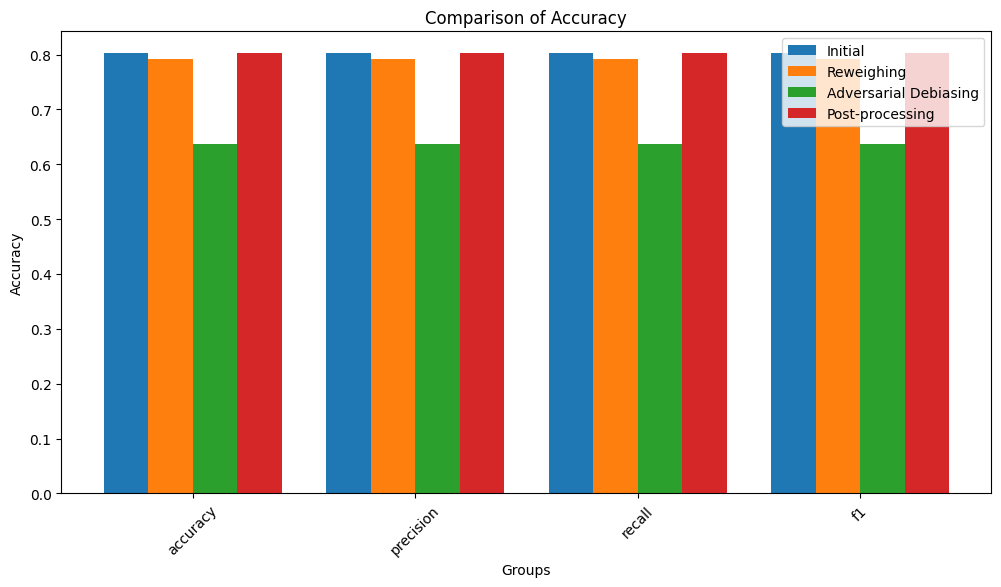

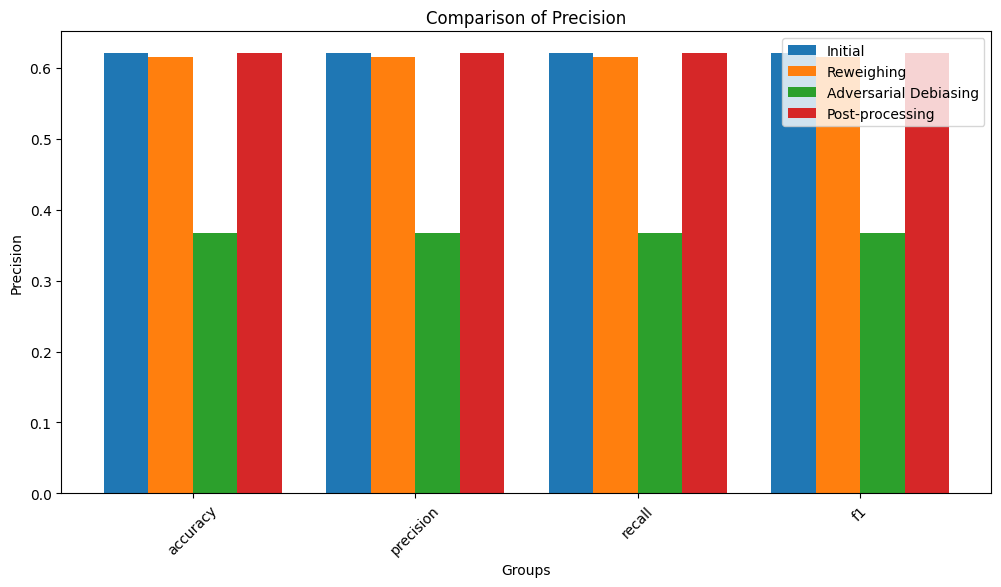

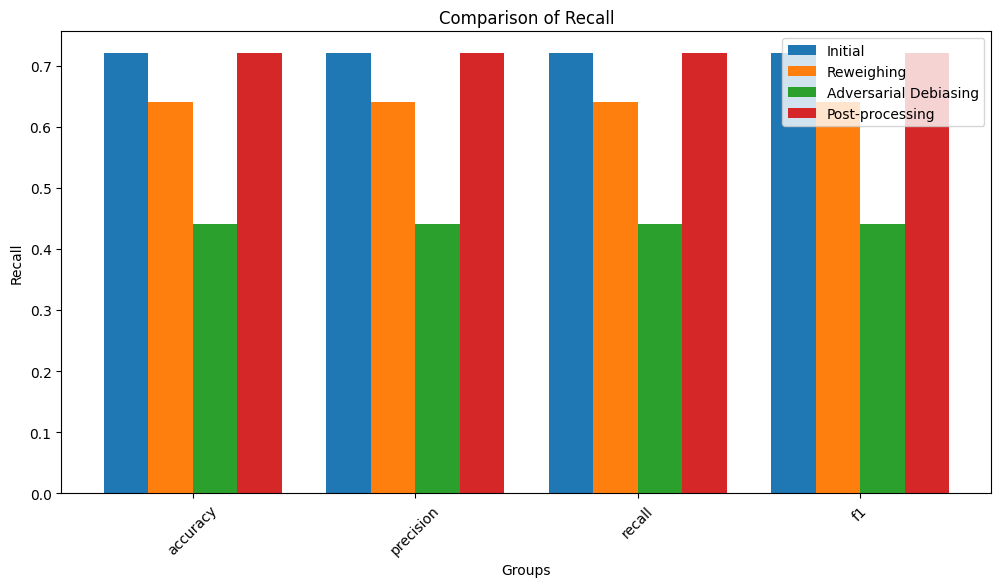

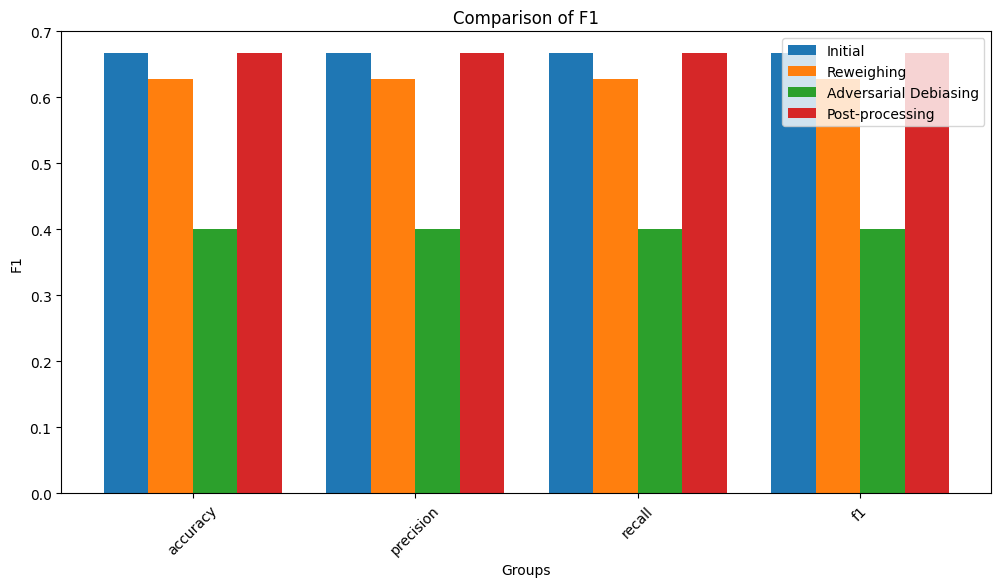

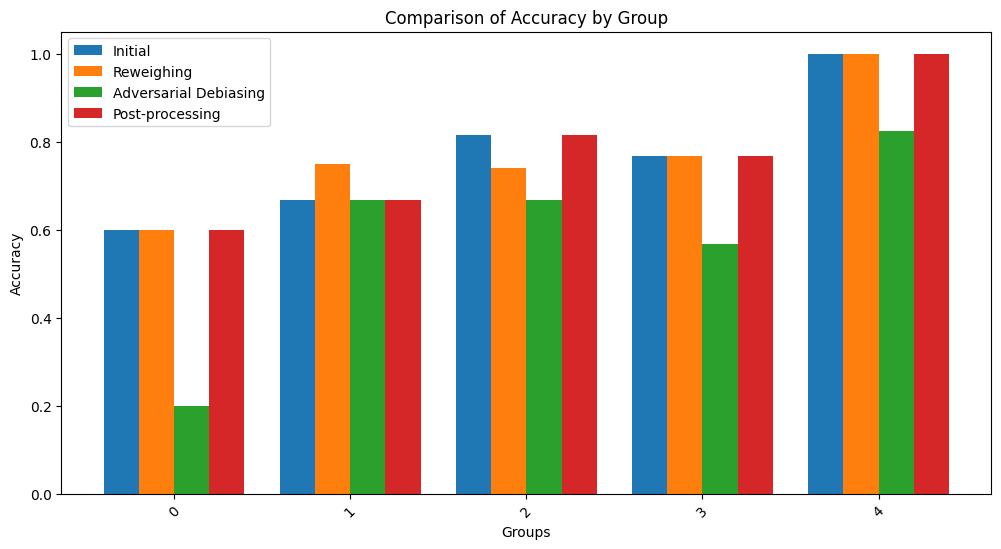

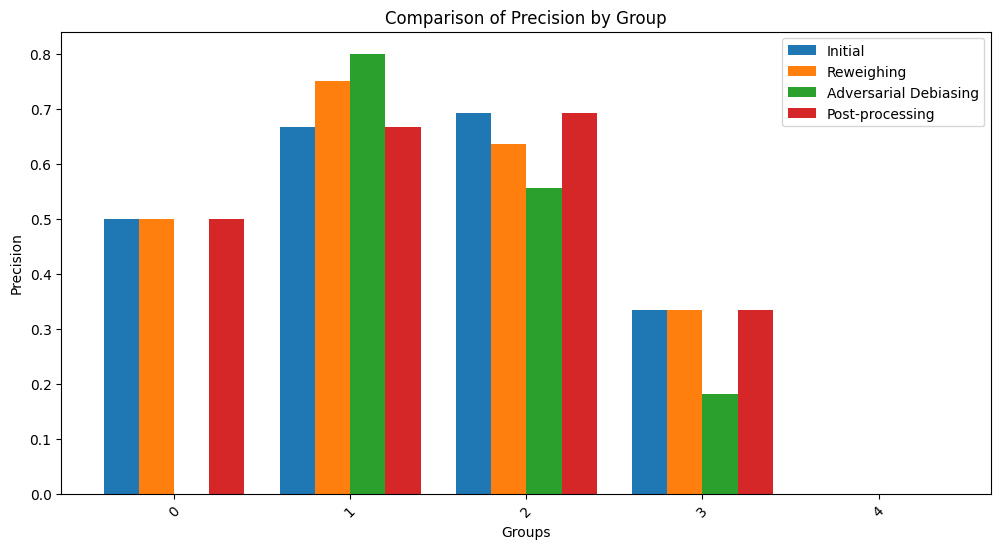

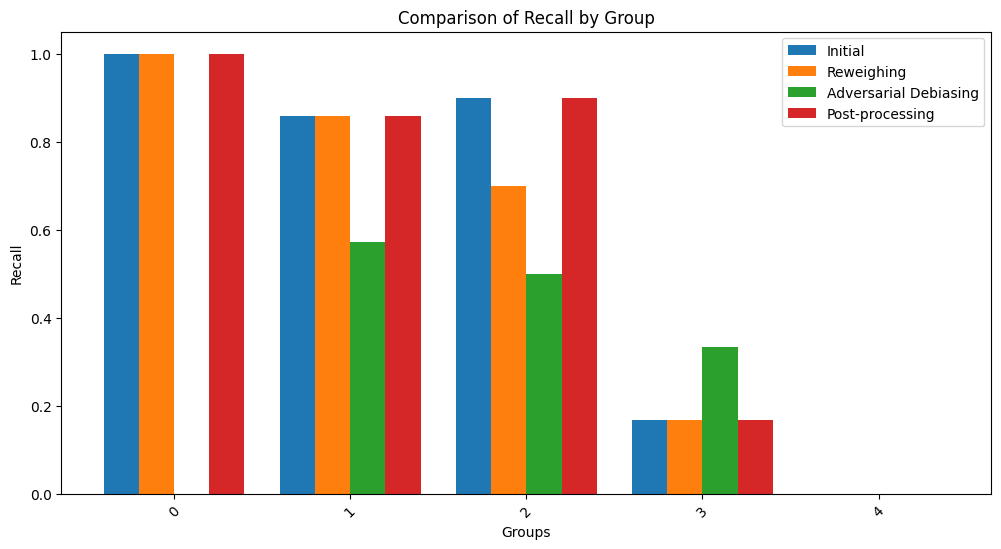

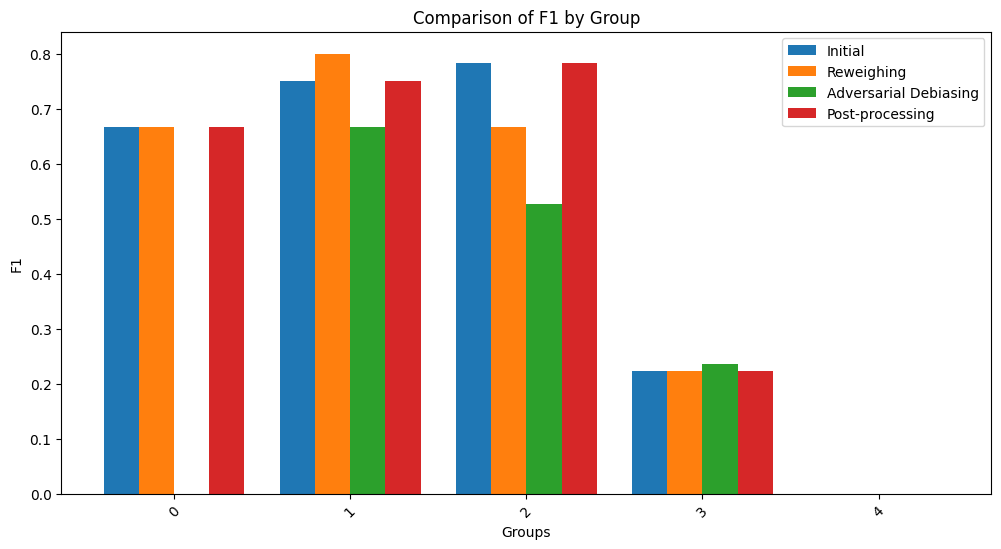

In [14]:
# Extracting overall metrics
overall_metrics_initial = metrics.overall
overall_metrics_rw = metrics_rw.overall
overall_metrics_ad = metrics_ad.overall
overall_metrics_pp = metrics_pp.overall

# Plot overall metrics comparison
def plot_overall_metric_comparison():
    metric_names = ['accuracy', 'precision', 'recall', 'f1']
    for metric in metric_names:
        plot_metric_comparison(
            overall_metrics_initial, overall_metrics_rw, overall_metrics_ad, overall_metrics_pp, 
            metric, metric.replace('_', ' ').title(), f'Comparison of {metric.replace("_", " ").title()}'
        )

# Plot overall metric comparison
plot_overall_metric_comparison()

# Plot metrics by group comparison
def plot_metrics_by_group_comparison(metrics_by_group_initial, metrics_by_group_rw, metrics_by_group_ad, metrics_by_group_pp):
    metric_names = ['accuracy', 'precision', 'recall', 'f1']
    for metric in metric_names:
        plot_metric_comparison(
            metrics_by_group_initial, metrics_by_group_rw, metrics_by_group_ad, metrics_by_group_pp, 
            metric, metric.replace('_', ' ').title(), f'Comparison of {metric.replace("_", " ").title()} by Group'
        )

# Extracting metrics by group
metrics_by_group_initial = metrics.by_group
metrics_by_group_rw = metrics_rw.by_group
metrics_by_group_ad = metrics_ad.by_group
metrics_by_group_pp = metrics_pp.by_group

# Plot metrics by group comparison
plot_metrics_by_group_comparison(metrics_by_group_initial, metrics_by_group_rw, metrics_by_group_ad, metrics_by_group_pp)

# Summary plot to show model improvement
def plot_model_improvement(summary_metrics):
    fig, ax = plt.subplots(figsize=(12, 6))
    labels = summary_metrics.index
    x = np.arange(len(labels))
    width = 0.2

    rects1 = ax.bar(x - width * 1.5, summary_metrics['Initial'], width, label='Initial')
    rects2 = ax.bar(x - width / 2, summary_metrics['Reweighing'], width, label='Reweighing')
    rects3 = ax.bar(x + width / 2, summary_metrics['Adversarial Debiasing'], width, label='Adversarial Debiasing')
    rects4 = ax.bar(x + width * 1.5, summary_metrics['Post-processing'], width, label='Post-processing')

    ax.set_xlabel('Metrics')
    ax.set_ylabel('Values')
    ax.set_title('Model Improvement through Bias Mitigation Steps')
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=45)
    ax.legend()

    plt.show()


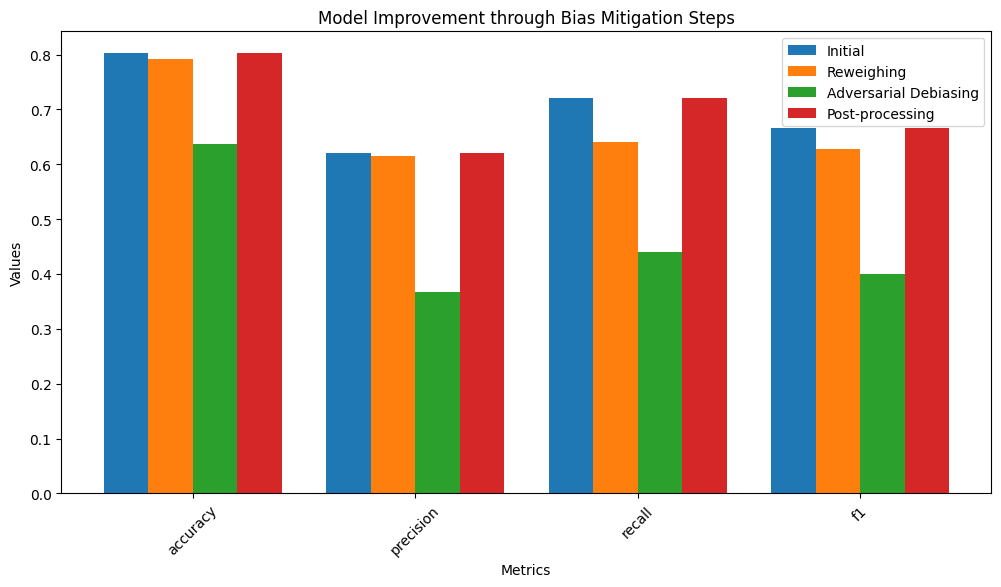

Done


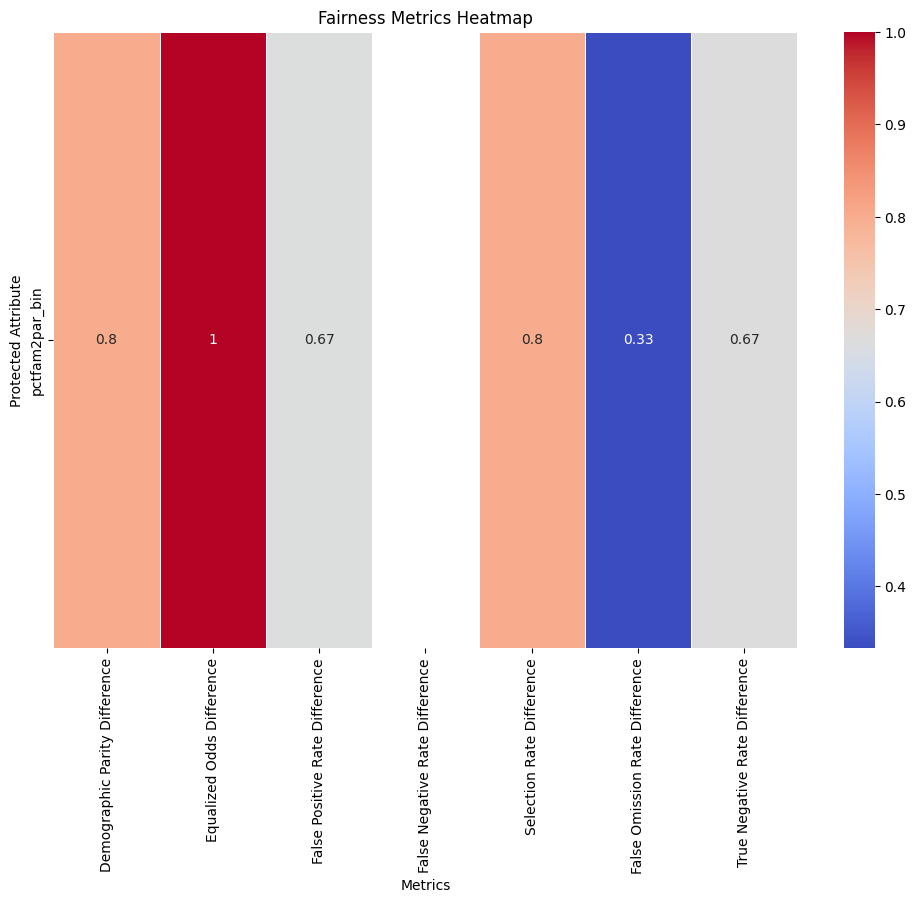

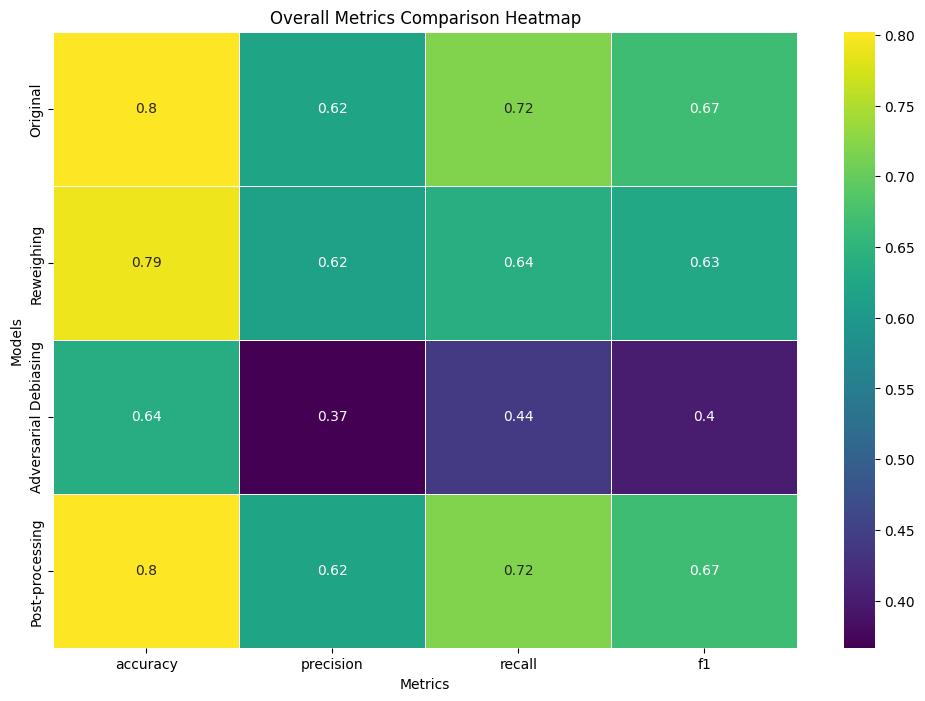

In [15]:
# Creating a DataFrame to summarize overall metrics for final improvement plot
summary_metrics = pd.DataFrame({
    'Initial': overall_metrics_initial,
    'Reweighing': overall_metrics_rw,
    'Adversarial Debiasing': overall_metrics_ad,
    'Post-processing': overall_metrics_pp
})

# Plot model improvement summary
plot_model_improvement(summary_metrics)

print("Done")

import seaborn as sns

# Create heatmap for fairness metrics
metrics_heatmap_data = pd.DataFrame({
    'Demographic Parity Difference': [dpd],
    'Equalized Odds Difference': [eod],
    'False Positive Rate Difference': [fprd],
    'False Negative Rate Difference': [fnrd],
    'Selection Rate Difference': [srd],
    'False Omission Rate Difference': [for_diff],
    'True Negative Rate Difference': [tnr_diff]
}, index=['pctfam2par_bin'])

plt.figure(figsize=(12, 8))
sns.heatmap(metrics_heatmap_data, annot=True, cmap='coolwarm', cbar=True, linewidths=0.5)
plt.title('Fairness Metrics Heatmap')
plt.ylabel('Protected Attribute')
plt.xlabel('Metrics')
plt.show()

# Comparison heatmap for overall metrics
comparison_heatmap_data = pd.DataFrame({
    'Original': overall_metrics_initial,
    'Reweighing': overall_metrics_rw,
    'Adversarial Debiasing': overall_metrics_ad,
    'Post-processing': overall_metrics_pp
}).transpose()

plt.figure(figsize=(12, 8))
sns.heatmap(comparison_heatmap_data, annot=True, cmap='viridis', cbar=True, linewidths=0.5)
plt.title('Overall Metrics Comparison Heatmap')
plt.ylabel('Models')
plt.xlabel('Metrics')
plt.show()


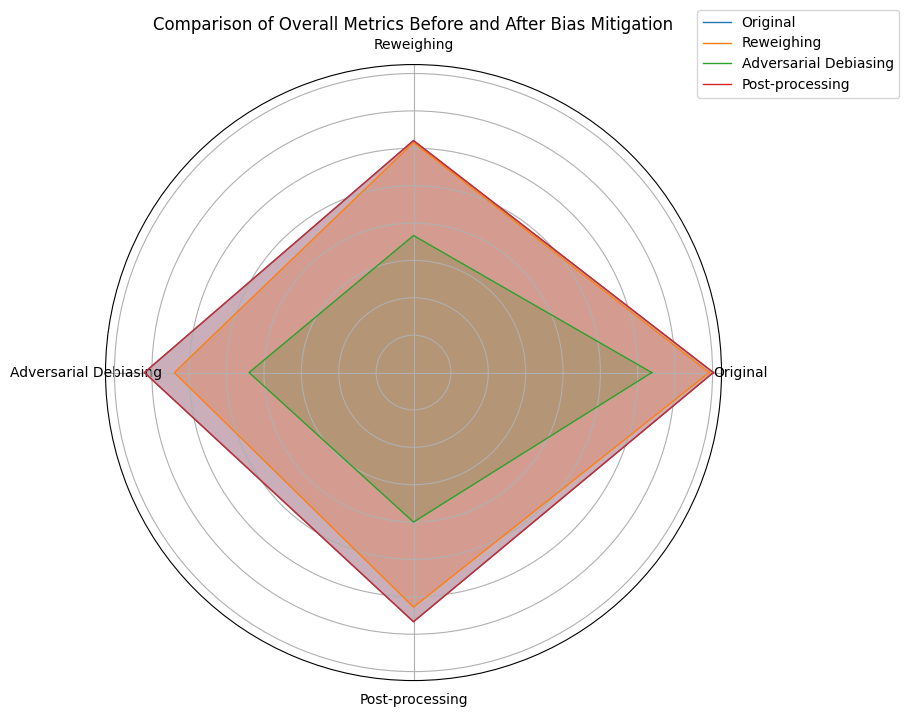

Additional visualizations done.


In [16]:
# Radar plot for visual comparison
from math import pi

def plot_radar_chart(metrics_dict, title):
    labels = list(metrics_dict.keys())
    num_vars = len(labels)

    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

    for model, metrics in metrics_dict.items():
        values = list(metrics.values())
        values += values[:1]
        ax.plot(angles, values, linewidth=1, linestyle='solid', label=model)
        ax.fill(angles, values, alpha=0.25)

    ax.set_yticklabels([])
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    plt.title(title)
    plt.show()

metrics_for_radar = {
    'Original': overall_metrics_initial.to_dict(),
    'Reweighing': overall_metrics_rw.to_dict(),
    'Adversarial Debiasing': overall_metrics_ad.to_dict(),
    'Post-processing': overall_metrics_pp.to_dict()
}

plot_radar_chart(metrics_for_radar, 'Comparison of Overall Metrics Before and After Bias Mitigation')

print("Additional visualizations done.")



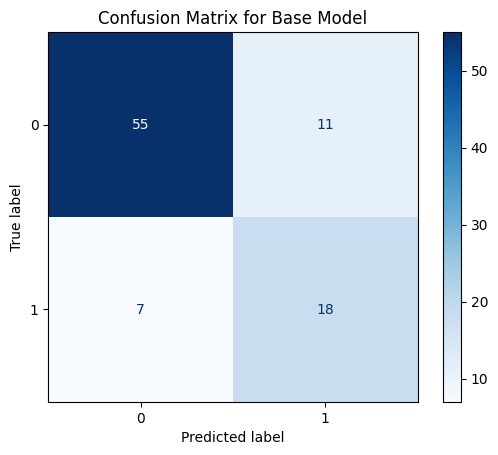

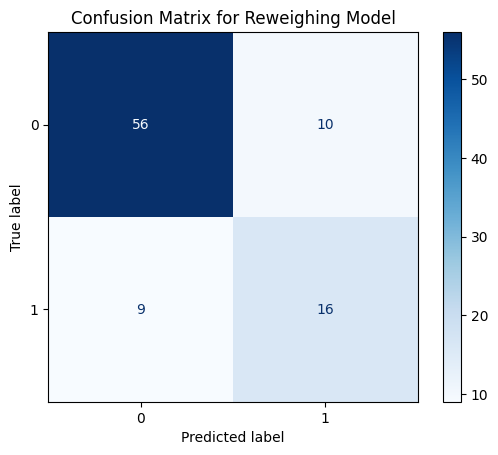

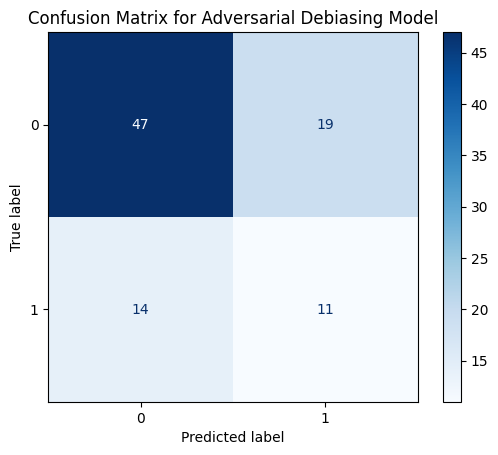

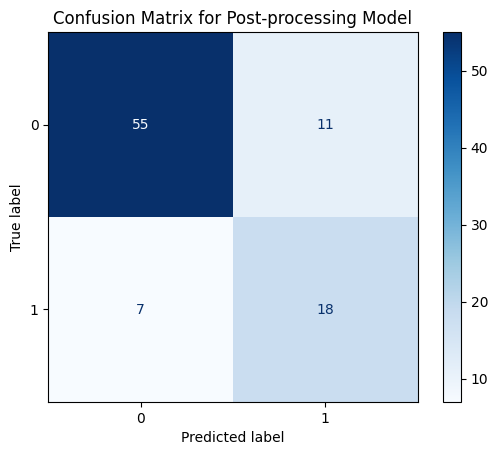

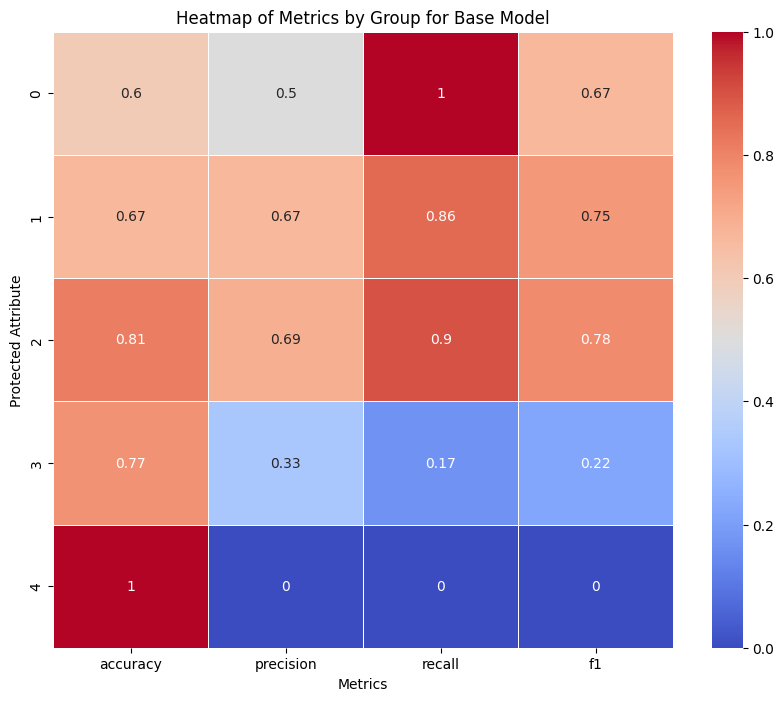

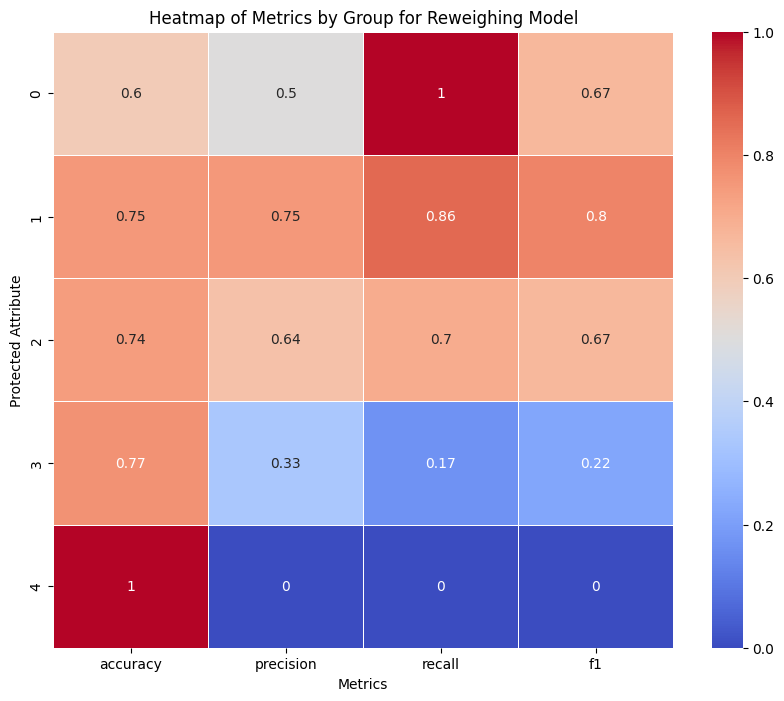

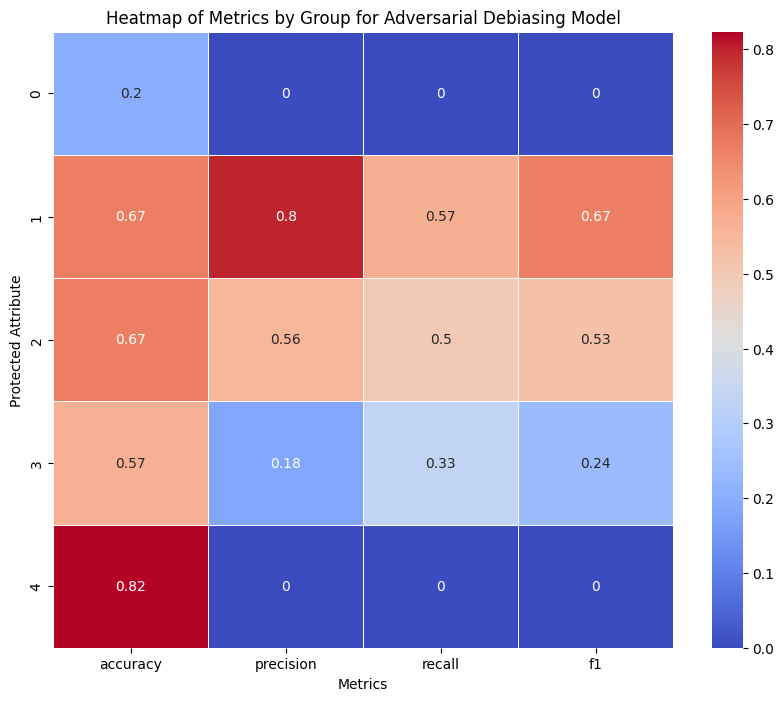

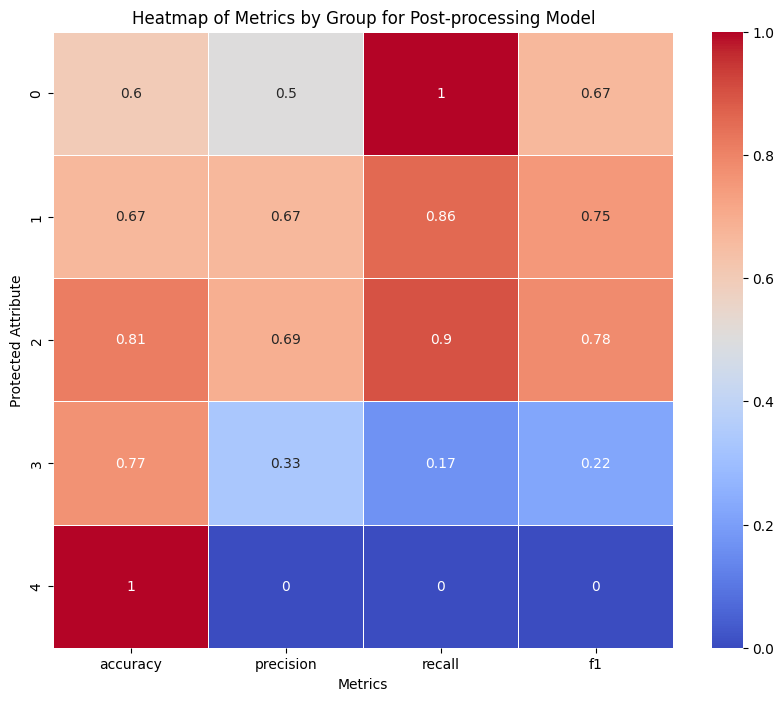

Additional confusion matrices and heatmaps done.


In [18]:
# Display confusion matrix for each model

def plot_confusion_matrix(model_name, y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

# Confusion matrices for each model
plot_confusion_matrix("Base Model", y_test, y_pred)
plot_confusion_matrix("Reweighing Model", y_test, y_pred_rw)
plot_confusion_matrix("Adversarial Debiasing Model", y_test, y_pred_ad)
plot_confusion_matrix("Post-processing Model", y_test, y_pred_pp)

# Heatmap for each model individually
def plot_model_heatmap(model_name, metrics_by_group):
    plt.figure(figsize=(10, 8))
    sns.heatmap(metrics_by_group, annot=True, cmap='coolwarm', cbar=True, linewidths=0.5)
    plt.title(f'Heatmap of Metrics by Group for {model_name}')
    plt.ylabel('Protected Attribute')
    plt.xlabel('Metrics')
    plt.show()

# Heatmaps for each model
plot_model_heatmap("Base Model", metrics_by_group)
plot_model_heatmap("Reweighing Model", metrics_by_group_rw)
plot_model_heatmap("Adversarial Debiasing Model", metrics_by_group_ad)
plot_model_heatmap("Post-processing Model", metrics_by_group_pp)

print("Additional confusion matrices and heatmaps done.")



In [20]:
# Calculate fairness metrics for all models
def calculate_fairness_metrics(y_true, y_pred, sensitive_features):
    dpd = demographic_parity_difference(y_true, y_pred, sensitive_features=sensitive_features)
    eod = equalized_odds_difference(y_true, y_pred, sensitive_features=sensitive_features)
    fprd = false_positive_rate_difference(y_true, y_pred, sensitive_features=sensitive_features)
    fnrd = false_negative_rate_difference(y_true, y_pred, sensitive_features=sensitive_features)
    srd = selection_rate_difference(y_pred, sensitive_features=sensitive_features)
    for_diff = false_omission_rate_difference(y_true, y_pred, sensitive_features=sensitive_features)
    tnr_diff = true_negative_rate_difference(y_true, y_pred, sensitive_features=sensitive_features)
    
    return {
        'Demographic Parity Difference': dpd,
        'Equalized Odds Difference': eod,
        'False Positive Rate Difference': fprd,
        'False Negative Rate Difference': fnrd,
        'Selection Rate Difference': srd,
        'False Omission Rate Difference': for_diff,
        'True Negative Rate Difference': tnr_diff
    }


C:\Users\Fujitsu\AppData\Local\Temp\ipykernel_9300\2464221156.py:8: RuntimeWarning: invalid value encountered in longlong_scalars
  return fn / (fn + tp)
C:\Users\Fujitsu\AppData\Local\Temp\ipykernel_9300\2464221156.py:8: RuntimeWarning: invalid value encountered in longlong_scalars
  return fn / (fn + tp)
C:\Users\Fujitsu\AppData\Local\Temp\ipykernel_9300\2464221156.py:8: RuntimeWarning: invalid value encountered in longlong_scalars
  return fn / (fn + tp)
C:\Users\Fujitsu\AppData\Local\Temp\ipykernel_9300\2464221156.py:8: RuntimeWarning: invalid value encountered in longlong_scalars
  return fn / (fn + tp)


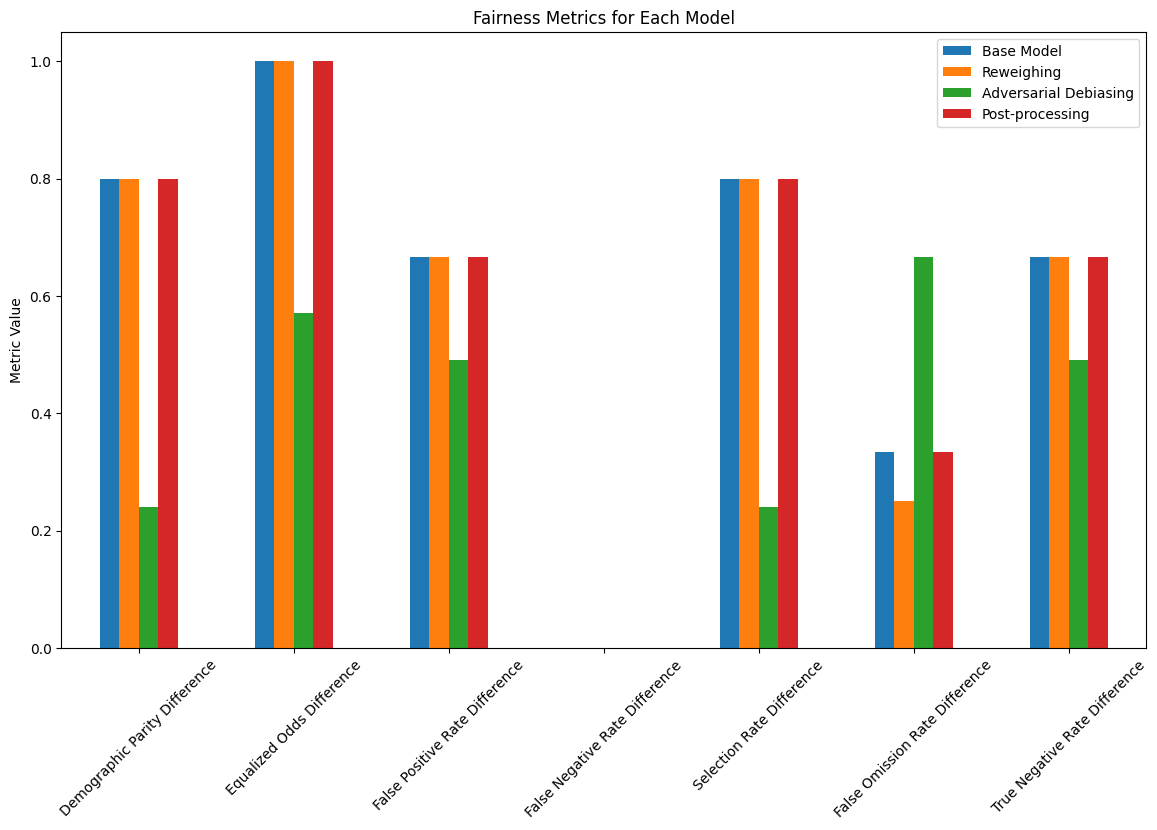

In [24]:
# Extract the relevant column from the data DataFrame
pctfam2par_bin = data.loc[X_test.index, 'PctFam2Par_bin']

# Fairness metrics for each model
fairness_metrics_base = calculate_fairness_metrics(y_test, y_pred, pctfam2par_bin)
fairness_metrics_rw = calculate_fairness_metrics(y_test, y_pred_rw, pctfam2par_bin)
fairness_metrics_ad = calculate_fairness_metrics(y_test, y_pred_ad, pctfam2par_bin)
fairness_metrics_pp = calculate_fairness_metrics(y_test, y_pred_pp, pctfam2par_bin)

# Create DataFrame for plotting
fairness_metrics_df = pd.DataFrame({
    'Base Model': fairness_metrics_base,
    'Reweighing': fairness_metrics_rw,
    'Adversarial Debiasing': fairness_metrics_ad,
    'Post-processing': fairness_metrics_pp
})

# Plot fairness metrics for each model
fairness_metrics_df.plot(kind='bar', figsize=(14, 8), title='Fairness Metrics for Each Model')
plt.ylabel('Metric Value')
plt.xticks(rotation=45)
plt.show()
